# Synopsis

This notebook is distributed  as part of the MDiGest python package.

In this tutorial, we show how to use the MDiGest python package to explore the different aspects of analysis of molecular dynamics trajectories, with the aim of extracting relevant information on allosteric properties of the simulated biomolecular systems through correlation analysis, community detection and dimensionality reduction methods. 




# Set up Colab environment

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

from google.colab import drive
drive.mount('/content/drive/')

### Create new environment with required packages

In [ ]:
# import mdigest.core.toolkit
# !pip install pyemma==2.5.12
# !pip install MDAnalysis==2.3.0
# !pip install silx==1.1.1
# !pip install numba==0.56.4
# !pip install python-louvain==0.15
# !pip install networkx==2.7.1
# !pip install nglview==3.0.3

In [ ]:
import os
os.chdir('/content/drive/')
with open('environment.yml') as f:
    f.write("name: mdigestenv\n")
    f.write(" channels:\n")
    f.write(" - conda-forge\n")
    f.write(" - schrodinger\n")
    f.write(" dependencies:\n")
    f.write(" # required for building docs\n")
    f.write("   - python=3.10\n")
    f.write("   - pip\n")
    f.write("   - numpy<=1.24.3\n")
    f.write("   - scipy>=1.10.0\n")
    f.write("   - numba==0.56.4\n")
    f.write("   - python-louvain==0.15\n")
    f.write("   - pymol-open-source\n")
    f.write("   - pandas\n")
    f.write("   - seaborn\n")
    f.write("   - mdtraj\n")
    f.write("   - pyemma\n")
    f.write("   - MDAnalysis\n")
    f.write("   - silx\n")
    f.write("   - nglview\n")
    f.write("   - networkx\n")
    f.write(" \n")

! mamba env update -n base -f environment.yml

### install MDiGest in conda environment

In [ ]:
!pip install mdigest

In [ ]:
! pip show mdigest


### Notes

### N.B. When running in colab the following steps need to be fulfilled before proceding to the next steps:
1) Download the trajectories here
    * IGPS: https://drive.google.com/drive/folders/1XK8X18NJQY-dQUrQaeCGZtSyKeaze5mr?usp=sharing
    * MptpA: https://drive.google.com/drive/folders/102mgn-bvH3GazRoMTlNqaEN6tilUJqZw?usp=sharing
2) Upload the trajectories  to the drive
3) Adjust the following variables
    - *currdir* : folder containing the trajectories folder
    - *savepath*: where to save outputs

### N.B. When running locally the following steps need to be fulfilled before proceding to the next steps:
1) Download the trajectories here
    * IGPS: https://drive.google.com/drive/folders/1XK8X18NJQY-dQUrQaeCGZtSyKeaze5mr?usp=sharing
    * MptpA: https://drive.google.com/drive/folders/102mgn-bvH3GazRoMTlNqaEN6tilUJqZw?usp=sharing

2) Adjust the following variables
    - *currdir* : folder containing the trajectories folder
    - *savepath*: where to save outputs

# **Test Case 1**: Correlations from MD
On how to compute **correlations from molecular dynamics (MD) simulations**, applied to Protein Tyrosine Phosphatase A from Mycobacterium Tubercolosis (**MptpA)**

## Synopsis

This notebook uses the MDiGest python software to carry out a correlation analysis of Protein Tyrosine phosphatase A (PTPA) in its wild type state (WT) as opposed to a mutant (Q75L). 
The notebook is meant to show the reader how different correlation metrics can be used (and compared) to gain insight on the dynamics of PTPA and how this is perturbed upon mutation of Q75 to Leucine. Removal of the polar side chain of Q75 by mutation to leucine results in a cascade of events that reposition the acid loop over the active site and relocates the catalytic aspartic acid (D126) at an optimal position for proton donation to the leaving aryl group of the substrate and for subsequent hydrolysis of the thiophosphoryl intermediate. 
The analysis can be generalyzed to different systems. 

### Dynamics of PTPA

All PTPs contain a phosphate-binding loop (P-loop; C11-S18, in yellow with the consensus sequence C(X)5R(S/T) as well as a loop containing the catalytically essential aspartic acid (acid loop), shown in green, that are both intimately involved in the PTP catalytic mechanism. Upon initial substrate binding, the phosphate moiety of the substrate binds to the P-loop, making a stabilizing interaction with the sidechain of the conserved Arg residue (R17, MptpA nomenclature) in this loop. 
Like the well-studied PTP enzymes (YopH and PTP1B), the acid loop must reposition over the active site to locate the catalytic acid (D126) for proton donation to the leaving aryl group of the substrate. Concurrent with this, the cysteine nucleophile (C11) attacks the phosphorus of the substrate generating a thiophosphate intermediate (that binds in the active site). In the subsequent hydrolysis step, and in analogy to other PTP enzymes, the acid loop must correctly position D126 to aid in the deprotonation of a water molecule to facilitate hydrolysis of the covalent intermediate that is followed by the release of phosphate and regeneration of active enzyme. Similar to other PTPs, the acid loop in MptpA is mobile and allows for conformational flexibility, and the presence of the ligand influences its conformation. It is known that the dynamics of wtMptpA involve the transient formation of active (closed) and inactive (open) states, the relative population of which modulates the catalytic activity. 

In the following we will analyze the dynamical (allosteric) motions that regulate the interconversion between these states remains, through the analysis of correlations from MD.

---








## Background and Introduction

Correlated motions in biomolecules are often essential for their function, e.g., **allosteric signal transduction or mechanical/thermodynamic energy transport**.

To some extent, correlated motions in biomolecules can be captured experimentally, for instance through NMR relaxation experiments, however, the resulting signals are often limited by overcrowding of the corresponding spectrum and are only feasible for protein segments of small-medium sizes (<~ 200 residues).

Molecular dynamics (MD) simulations are particularly useful for the analysis of correlated motions and can be used to understand the complex interplay of reciprocated interaction between the different residues, over different timescales.

A convenient way to model a set of objects in relation is by using a network (also called graph). Using graph theory, any protein can be represented as network whose nodes are its amino acids (AA) residues and the by edges connecting them are propotional to the strength of the coupling (correlation) between them.
Many approaches have been proposed to quantify such correlation from MD simulations, for instance via calculation of the covariance matrix of atomic displacements, and related quantities such as dynamical cross correlation, pearson correlation ecc.

Regardless of the formalism used to quantify the correlation between each pair of residues, the output is an **AA-protein correlation network (PCN)** which can be used to extract useful information on the **close-and-far connections that enable the signal transduction across the protein**, which guide the formation of essential interaction that determine protein structure and function.

Then, the dynamics (set of observation collected from MD) of each pair of residues is described by two jointly distributed real-valued random variables ${\displaystyle X}$ and ${\displaystyle Y}$, whose  covariance is defined as:

 $${\displaystyle \operatorname {cov} (X,Y)=\operatorname {E} {{\big [}(X-\operatorname {E} [X])(Y-\operatorname {E} [Y]){\big ]}}}, $$

Because covariance values are not standardized it can be useful to convert them to normalized quantities such as Pearson correlation values $\rho_{X,Y}$ defined as:

$${\displaystyle \rho _{X,Y}={\frac {\operatorname {cov} (X,Y)}{\sigma _{X}\sigma _{Y}}}}, $$

or dynamical cross correlation coefficients:

$$dcc(X,Y) = \frac{\langle cov(X,Y)\rangle}{\langle {\sigma _{X}\sigma _{Y}} \rangle}, $$

where $\langle \cdot \rangle$ denotes a time ensemble average.
Despite  being  relatively cheap to calculate, these metrics do not account for non-linear contributions to correlations, and fail to asses correlations in perpendicular motion of atoms.  A popular metric that overcomes said pitfalls is the generalized  correlation  coefficient, based on Shannon mutual information (MI)

$$ MI(X,Y) =  H[X] + H[Y] - H[X,Y], $$

where H[X], H[Y] are the information content (entropy) of the marginal distributions of X and Y, and H[X,Y] is the joint entropy.
Generalized correlation coefficients ($rMI[X,Y]$) are then defined as

$$rMI[X,Y] = (1- exp(-\frac{2}{3}I[X,Y]))^{1/2}$$

and capture noncollinear correlations between pairs of residues, thereby revealing how much each pair of residues is affected/perturbed by the motion of each other pair.
The inclusion of nonlinearities, however, comes at the cost of a significant increase in computational effort, as compared to more simple covariance based analyses.
Linear generalized correlations ($rLMI[X,Y]$) reduce the computational cost of the calculation of $rMI[X,Y]$ by relying on a Gaussian estimator to evaluate mutual information, resulting in a metric that is most cases very close to $rMI[X,Y]$ - accounting for orthogonal correlation but neglecting non-linear contributions, and related to $cov(X,Y)$ as:

 $$ LMI[X,Y] = [\mathrm{ln}(\mathrm{det}(cov(X))) + \mathrm{ln}(\mathrm{det}(cov(Y)))-  \mathrm{ln}(\mathrm{det}(cov(X,Y)))].$$
 
 This very short and by no means exhaustive description of popular correlation metrics is instrumental to introduce the reader to the standard approaches when it comes to quantifying the coupled motions of AA from MD.

### Motivation

Despite the wide spread use of such metrics a there is lack for a "standardized use" of such methodologies, such that often times one one metric is preferred over another rather arbitrarily, and the resulting inaccurate interpretations, where the key modulators of the allosteric dynamics change depending of the chosen approach.
The comparison of different metrics is essential for unequivocal indentification of the main modulators of the (allosteric) dynamics of a given protein, and for a correct validation of the outcomes.
Although many tools have been published in the last years to perform such kind of analysis there is still need for standardizing the such kinds of analysis in an effort to improve reproducibility, increase transparency and allow for an easier usage. Currently available tools suffer from limitations in terms of input formats, supported network models and versionning control, which limit their usability. Wrappers that unify many different packages exist, which, however also very hard to navigate, due to hardly controllable internal options.

Besides, with the simulations growing longer (and larger) there is the need of using capturing correlated behavior in the presence of large domain motion. This call for the use of internal coordinates rather than atomic displacements which depend on the reference frame used for trajectory alignment. Different definitions of coordinate independent metrics have been proposed including torsional networks, contact networks, and interaction networks. These however suffer vararious flaws related to the interdependency of torsional degrees of freedom, and selection of distance cutoffs, which ultimately affect the results of the analysis.

We propose a self-contained / easy to use package based on a modular structure, which allows the straightforward comparison of different correlation networks. 
For the same topology and  MD trajectory, the network can be constructed based on correlation of atom movement or dihedrals, or through an novel proposed approach based on the correlation of electrostatic interaction energies.  

Moreover, for example for atomic fluctuation based correlation, the PCN can be constructed based on the movement of any combination of selections or its center of mass. Implemented correlation metrics are for both atomic displacements, torsional based and electrostatic based networks are Covariance, Pearson’s correlation coefficient, Dynamic cross correlation, Mutual Information (MI) or Linear MI (LMI). 
The output of the correlation analysis can be saved to file for later use. 
The resulting PCNs can be analysed through different community analysis algorithms including GN, Louvain heuristic algorithm and a newly proposed approach based on the construction on correlation of hignly connected Secondary structure blocks. The results can be analyzed in pymol.




## Import MDiGest packages

In [ ]:
# import source code
import mdigest
# import parsetrajectory module
from mdigest.core.parsetrajectory import *

# import correlation modules
from mdigest.core.correlation import *
from mdigest.core.dcorrelation import *
from mdigest.core.kscorrelation import *

# import auxiliary functions module
import mdigest.core.auxiliary as aux

# import plots module
from mdigest.core.plots.general_plots import *
from mdigest.core.plots.plot_correlation import *

# import imports module
from mdigest.core.imports import *

# import save_data module
import mdigest.core.savedata as sd

import warnings
from importlib import reload
warnings.filterwarnings("ignore")

In [ ]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# For visualization
from pymol import cmd
#import nglview as nv
import ipywidgets as widgets
plt.rcParams.update({'font.size': 30})

## Compute Correlations

### Set paths

In [19]:
# Download the trajectories at the following link:
# "https://drive.google.com/drive/folders/102mgn-bvH3GazRoMTlNqaEN6tilUJqZw?usp=sharing"
# define trajectory and topology files

# change path accordingly: this is the path to the trajectories
parent = '/Volumes/GoogleDrive-112881197181043313538/Shared drives/PUBLIC/MptpA/'

# change path accordingly: assign this path to be the folder where you want your results to be saved.
currdir = '/Users/federica/Downloads/'

# define trajectory files
topology_WT     = parent + 'dry_1U2P.psf'
topology_Q75L   = parent + 'dry_1U2P_Q75L.psf'
trajectory_WT   = [ parent + 'dry_1U2P_2_200ns.dcd', parent + 'dry_1U2P_3_200ns.dcd', parent + 'dry_1U2P_4_200ns.dcd']
trajectory_Q75L = [ parent + 'dry_1U2P_Q75L_2_200ns.dcd', parent + 'dry_1U2P_Q75L_3_200ns.dcd', parent + 'dry_1U2P_Q75L_4_200ns.dcd']

# define path to output folder 
savedir = currdir + '/mdigest-RESULTS/'
# create savedir if not there
mdigest.core.toolkit.folder_exists(savedir)

### Parse Trajectories through the `parsetrajectory` module

Molecular dynamics (MD) trajectories are the core object which we intend to use to extract useful information on the allosteric behavior of a given protein.

A succesful analysis start by parsing the MD trajectory correctly.

The MDS (molecular dynamics simulation) class is devised to allow one to load topology and trajectory files and perform various actions it, such as:

   1. Divide the trajectory in multiple blocks corresponding to the different replicas:
      it can be useful to analyze multiple replicas at once; given a collection of independent replicas of a given system, one can pass a list of trajectories as `trajs=['traj1.dcd', 'traj2.dcd', ... ]` to the MDS class and set the MDS class to read in the list of trajectories as separate entries.
      As a result the analysis performed subsequently will return lists (or dictionaries) where each entry corresponds to each independent replica.
      Similarly, one can load a single concatenated trajectory traj='trajectory.dcd' and just set the number of replicas to the desider number n (through set_num_replicas(n), and impose that the trajectory shall be parsed as n independent chunks.
   
   
   2. Align the trajectory to a given reference frame or within - to the first frame
 
 
   3. Selecting the portion of the system to include for analysis throught the `set_selection` function:
      typically one may want to select a subset of atoms on which to compute correlation, for instance CA carbons.
      To this end, one can pass a string to the MDS class to select a subset of atoms to perform correlation or other analyses on.
      Notice that this promiscuous selection is only relevant for atomic displacements related correlation metrics.
      `dihedral_correlation.py` and `KS_correlation.py` modules imply a number of nodes (nnodes) equivalent to the number of residues.
      A common selection is to use alpha carbons, which can be set using set_selection(`'protein and name CA'`, `'protein'`).


   4. Alternatively one may want to use a selection that includes more than a node per residue, such as "backbone". Alternative options of interest might include protein and non-protein atom types. Both of these options are possible and can be enforced. The string selection follows the MDAnalysis syntax, which enables easy selection of different set of nodes on which to perform the analysis.


   5. Another useful procedure consists in selecting a desired subset of frame and striding the trajectory to achieve a desired timestep in the analysis. This can be done using the stride_trajectory option.

In [5]:
mdsWT = MDS()
# set number of replicas
mdsWT.set_num_replicas(1) # use 2 if you have 2 replicas.
# load topology and trajectory files into MDS class
mdsWT.load_system(topology_WT, trajectory_WT)
# align trajectory
mdsWT.align_traj(inMemory=True, selection='name CA')
# set selections for MDS class
mdsWT.set_selection('protein and name CA', 'protein')
# stride trajectory
mdsWT.stride_trajectory(initial=0, final=-1, step=5)

  0%|          | 0/15000 [00:00<?, ?it/s]

@>: number of frames:      15000
@>: number of replicas:    1
@>: using window length of 3000 simulation steps
@>: number or frames per replica: 3000
@>: first frame:           0
@>: last frame:            15000
@>: step:                  5
@>: number of residues in selected atom group: 163
@>: number of nodes    in selected atom group: 163
@>: number of elements in selected atom group: 163


In [6]:
# parse Q75L trajectory
mdsQ75L = MDS()
# set number of replicas
mdsQ75L.set_num_replicas(1) # use 2 if you have 2 replicas.
# load topology and trajectory files into MDS class
mdsQ75L.load_system(topology_Q75L, trajectory_Q75L)
# align trajectory
mdsQ75L.align_traj(inMemory=True, selection='name CA')
# set selections for MDS class
mdsQ75L.set_selection('protein and name CA', 'protein')
# stride trajectory
mdsQ75L.stride_trajectory(initial=0, final=-1, step=5)


  0%|          | 0/15000 [00:00<?, ?it/s]

@>: number of frames:      15000
@>: number of replicas:    1
@>: using window length of 3000 simulation steps
@>: number or frames per replica: 3000
@>: first frame:           0
@>: last frame:            15000
@>: step:                  5
@>: number of residues in selected atom group: 163
@>: number of nodes    in selected atom group: 163
@>: number of elements in selected atom group: 163


The verbose printing informs on the option selected for trajectory parsing.
The MDS class conveniently stores different MDAnalysis attributes that can be accessed, as shown below

The MDS class conveniently stores different MDAnalysis attributes that can be accessed as follows

In [ ]:
# check selected atomgroup
# print('----@>: Atom Group:\n', mds.atom_group_selection)
# print('----@>: Dictionary for converting between atom ids and residue ids (resids)\n', mds.nodes_to_res_dictionary)
# print('----@>: Number of atoms\n', mds.natoms)
# print('----@>: Number of nodes\n', mds.nnodes)
# print('----@>: Number of residues\n', mds.nresidues)


### Compute Correlations from MD using the *correlation* modules

*  `correlation` for atomic displacements, 
*  `dcorrelation`, for dihedral fluctuations, 
* `kscorrelation` for electrostatic energies  

MDigest efficiently computes correlations from different features, and with different approaches:
The available approaches which can be chosen to compute correlation are:
        - Mutual information based generalized correlation (MI)
        - Linearized mutual information based generalized correlation (LMI)
        - Pearson's correlation coefficient (PCC)
        - Dynamical cross correlation (DCC)
        - Covariance (COV)

The correlation analysis can be carried out using
       - atomic displacements (we use `protein and name CA` in the following, but any other selection would be possible)
       - dihedral fluctuations (at the moment only `phi and psi` dihedrals are included)
       - electrostatic energies (we construct a per residue `donor/acceptor`  electrostatic contribution at each frame of the trajectory
       using the Kabsch-Sander formlism)
as features.

In the following we show how to compute various correlation metrics from each feature, how to compare them,
discussing what insights can we gain from each.


In [7]:
%%time
# compute correlation from CA displacements for the WT trajectory
dyncorrWT = DynCorr(mdsWT)
dyncorrWT.parse_dynamics(scale=True, normalize=True, LMI='gaussian', MI='None', DCC=True, PCC=True, VERBOSE=True, COV_DISP=True)
# use MI=knn_5_2 to compute generalized based correlation of CA displacements

@>: sanity check pass: number of residues is same as number of nodes
@>: using window length of 3000 simulation steps
@> -- shape of coordinates matrix: (1, 3000, 163, 3)
@> -- shape of coordinates_allreplicas matrix: (1, 3000, 489)
@> -- shape of displacements_allreplicas matrix: (1, 3000, 489)
@> -- shape of disp_from_mean_allreplicas matrix: (1, 3000, 163)
@> -- shape of distances_allreplicas matrix: (1, 163, 163)
@> -- shape of covar_disp_allreplicas (1, 163, 163)
@> -- shape of dcc_allreplicas matrix: (1, 163, 163)
@> -- shape of pcc_allreplicas matrix: (1, 163, 163)


@>: LMI/MI calculation ...
@>: begin frame: 0
@>: end   frame: 15000
@>: step:        5
@>: compute covariance of displacements...
@>: reshaping coordinates...
@>: values array has shape (3000, 163, 3)


100%|██████████| 13366/13366 [00:03<00:00, 3832.41it/s]


@>: computing eigenvector centrality from lmi matrix
@>: computing and storing distances...
@>: computing normalized dynamical cross-correlation matrix
@>: computing pearson correlation matrix
CPU times: user 8.59 s, sys: 847 ms, total: 9.44 s
Wall time: 7.58 s


In [9]:
%%time
# compute correlation from CA displacements for the Q75L trajectorie
dyncorrQ75L = DynCorr(mdsQ75L)
dyncorrQ75L.parse_dynamics(scale=True, normalize=True, LMI='gaussian', MI=None, DCC=True, PCC=True, VERBOSE=True, COV_DISP=True) # use MI='knn_5_2' to compute MI
# use MI=knn_5_2 to compute generalized based correlation of CA displacements

@>: sanity check pass: number of residues is same as number of nodes
@>: using window length of 3000 simulation steps
@> -- shape of coordinates matrix: (1, 3000, 163, 3)
@> -- shape of coordinates_allreplicas matrix: (1, 3000, 489)
@> -- shape of displacements_allreplicas matrix: (1, 3000, 489)
@> -- shape of disp_from_mean_allreplicas matrix: (1, 3000, 163)
@> -- shape of distances_allreplicas matrix: (1, 163, 163)
@> -- shape of covar_disp_allreplicas (1, 163, 163)
@> -- shape of dcc_allreplicas matrix: (1, 163, 163)
@> -- shape of pcc_allreplicas matrix: (1, 163, 163)


@>: LMI/MI calculation ...
@>: begin frame: 0
@>: end   frame: 15000
@>: step:        5
@>: compute covariance of displacements...
@>: reshaping coordinates...
@>: values array has shape (3000, 163, 3)


100%|██████████| 13366/13366 [00:03<00:00, 3888.14it/s]


@>: computing eigenvector centrality from lmi matrix
@>: computing and storing distances...
@>: computing normalized dynamical cross-correlation matrix
@>: computing pearson correlation matrix
CPU times: user 7.55 s, sys: 414 ms, total: 7.96 s
Wall time: 5.32 s


In [10]:
%%time
# Kabsch-Sander analysis for correlation of electrostatic interactions in WT
KSWT = KS_Energy(mdsWT)
# select backbone atoms
KSWT.set_selection(['protein and backbone and name N','protein and backbone and name O',
                  'protein and backbone and name C','protein and name H'], system_selstr='protein')
# set indices according to atom name selection
KSWT.set_backbone_dictionary({'N-Backbone':'N',
                             'O-Backbone':'O',
                             'C-Backbone':'C',
                             'CA-Backbone':'CA',
                             'H-Backbone':'H'})

KSWT.KS_pipeline(topology_charges=False, MI=None, covariance=True, correction=True) # use MI='knn_5_2' to include MI
KSWT.compute_EEC(distance_matrix=None, loc_factor=None, don_acc=True)

@>: prepare kabsch sanders calculation
@>: run KS calculation


@>: KS energy calculation ...
@>: begin frame: 0
@>: end   frame: 15000
@>: step:        5
@>: computing distances in parallel


  0%|          | 0/3000 [00:00<?, ?it/s]

@>: values array has shape (3000, 163)
@>: values array has shape (3000, 163)
@>: values array has shape (3000, 163)


CPU times: user 7.88 s, sys: 1.23 s, total: 9.11 s
Wall time: 7.84 s


In [11]:
%%time
# Kabsch-Sander analysis for correlation of electrostatic interactions in Q75L
KSQ75L = KS_Energy(mdsQ75L)
# select backbone atoms
KSQ75L.set_selection(['protein and backbone and name N','protein and backbone and name O',
                  'protein and backbone and name C','protein and name H'], system_selstr='protein')
# set indices according to atom name selection
KSQ75L.set_backbone_dictionary({'N-Backbone':'N',
                             'O-Backbone':'O',
                             'C-Backbone':'C',
                             'CA-Backbone':'CA',
                             'H-Backbone':'H'})

KSQ75L.KS_pipeline(topology_charges=False, MI=None, covariance=True, correction=True) # use MI='knn_5_2' to include MI
KSQ75L.compute_EEC(distance_matrix=None, loc_factor=None, don_acc=True)

@>: prepare kabsch sanders calculation
@>: run KS calculation


@>: KS energy calculation ...
@>: begin frame: 0
@>: end   frame: 15000
@>: step:        5
@>: computing distances in parallel


  0%|          | 0/3000 [00:00<?, ?it/s]

@>: values array has shape (3000, 163)
@>: values array has shape (3000, 163)
@>: values array has shape (3000, 163)


CPU times: user 9.25 s, sys: 2.28 s, total: 11.5 s
Wall time: 9.97 s


In [ ]:
%%time
# compute correlation from dihedral fluctuations for the WT trajectory
dihdyncorrWT = DihDynCorr(mdsWT)
dihdyncorrWT.parse_dih_dynamics(mean_center=True, LMI='gaussian', MI='knn_5_2', DCC=True, PCC=True, COV_DISP=True)

In [ ]:
# compute correlation from dihedral fluctuations for the Q75L trajectory
%%time
dihdyncorrQ75L = DihDynCorr(mdsQ75L)
dihdyncorrQ75L.parse_dih_dynamics(mean_center=True, LMI='gaussian', MI='knn_5_2', DCC=True, PCC=True, COV_DISP=True)

We save the instances of each correlation class with the save_class function.
Once stored, one can reload all attributes of the correlation analysis into a macro-object using MDSdata. 

In [20]:
cachedir = savedir + 'CACHE/'

# save WT objects to file for later use
dyncorrWT.save_class(file_name_root=cachedir + 'dyncorrWT')
KSWT.save_class(file_name_root=cachedir + 'KS_WT', save_space=True)
dihdyncorrWT.save_class(file_name_root=cachedir + 'dih_WT')


# save Q75L objects to file for later use
dyncorrQ75L.save_class(file_name_root=cachedir + 'dyncorrQ75L')
KSQ75L.save_class(file_name_root=cachedir + 'KS_Q75L', save_space=True)
dihdyncorrQ75L.save_class(file_name_root=cachedir + 'dih_Q75L')


## Correlation Analysis

In [29]:
# define path to output folder and cache
cachedir = savedir + 'CACHE/'
mdigest.core.toolkit.folder_exists(cachedir)
results_dir = savedir + 'RESULTS/MptpA/'
mdigest.core.toolkit.folder_exists(results_dir)
rd = results_dir

Load cached outputs

In [22]:
KSWT_load = sd.MDSdata()
KSWT_load.load_from_file(file_name_root=cachedir + 'KS_WT', save_space=True)

# # double  load trick to have all class attributes from both dyncorr and KS analysis in one

dyncorrWT_load = KSWT_load
dyncorrWT_load.load_from_file(file_name_root=cachedir + 'dyncorrWT')
dyncorrWT_load.load_from_file(file_name_root=cachedir + 'dih_WT')


@>: cached file found: loading  /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_cache.hf
@>: is_proline int32 (163,) 163
    Done loading is_proline attribute
@>: is_protein int32 (163,) 163
    Done loading is_protein attribute
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_DA_energies_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_DA_MI_corr_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_DA_LMI_corr_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_cov_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_eigvec_centrality_da_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_WT_eigvec_centrality_don_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACH

In [25]:
KSQ75L_load = sd.MDSdata()
KSQ75L_load.load_from_file(file_name_root=cachedir + 'KS_Q75L', save_space=True)

# # double  load trick to have all class attributes from both dyncorr and KS analysis in one

dyncorrQ75L_load = KSQ75L_load
dyncorrQ75L_load.load_from_file(file_name_root=cachedir + 'dyncorrQ75L')
dyncorrQ75L_load.load_from_file(file_name_root=cachedir + 'dih_Q75L')


@>: cached file found: loading  /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_cache.hf
@>: is_proline int32 (163,) 163
    Done loading is_proline attribute
@>: is_protein int32 (163,) 163
    Done loading is_protein attribute
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_DA_energies_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_DA_MI_corr_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_DA_LMI_corr_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_cov_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_eigvec_centrality_da_allrep.h5
@>: load /Users/federica/Downloads//mdigest-RESULTS/CACHE/KS_Q75L_eigvec_centrality_don_allrep.h5
@>: load /Users/federica/Downloads//md

Now that everything is loaded correctly we can finally do some analysis!

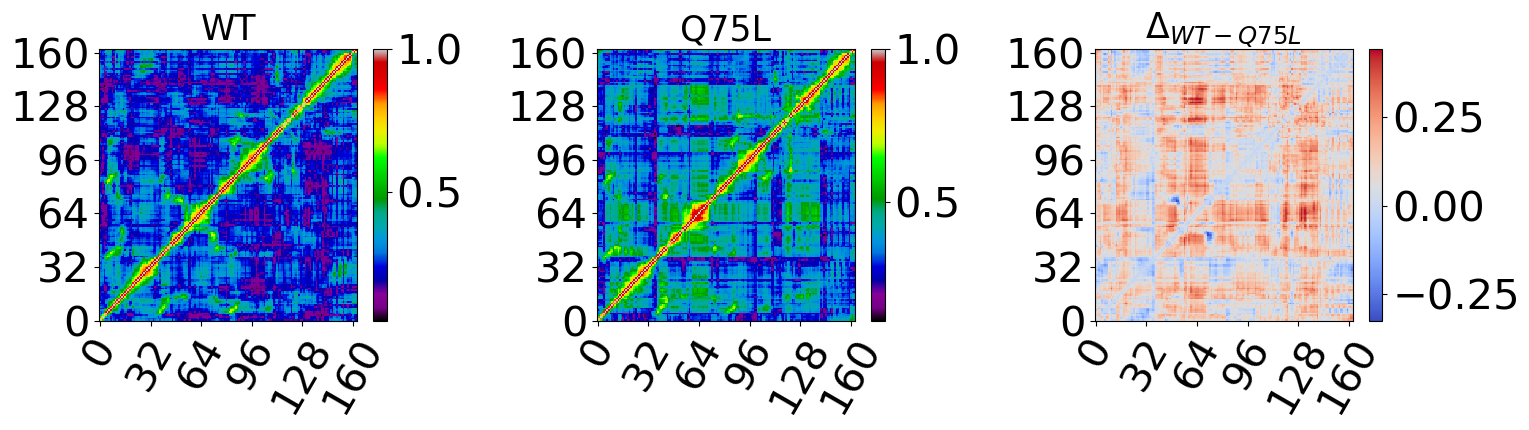

rep. 0
rep. = 0,  RED [ 57  61  64 122 131 133 134 138 141]
rep. = 0,  BLU [ 11  30  31  33  34  37 149 153 156]


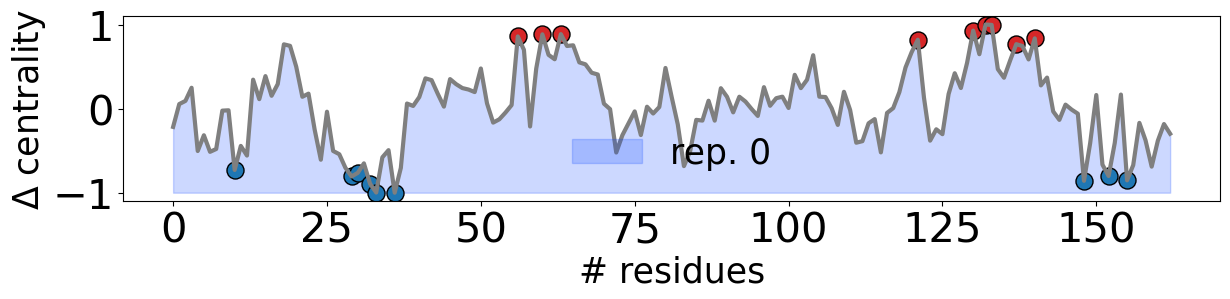

In [30]:
plots = Plots(dyncorrWT_load, dyncorrQ75L_load, matrix_type='gcc_lmi', save=rd + 'MptpA_ca_LMI')
plots.load_parameters({
            'fig': plt.subplots(1, 3, figsize=(16,5)),
            'labels': ['WT', 'Q75L']})
plots.plot_gcc_per_replica()

plots.load_parameters({
            'fig': plt.subplots(1+1,1, figsize=(13,6))})
plots.plot_eigcent_per_replica()


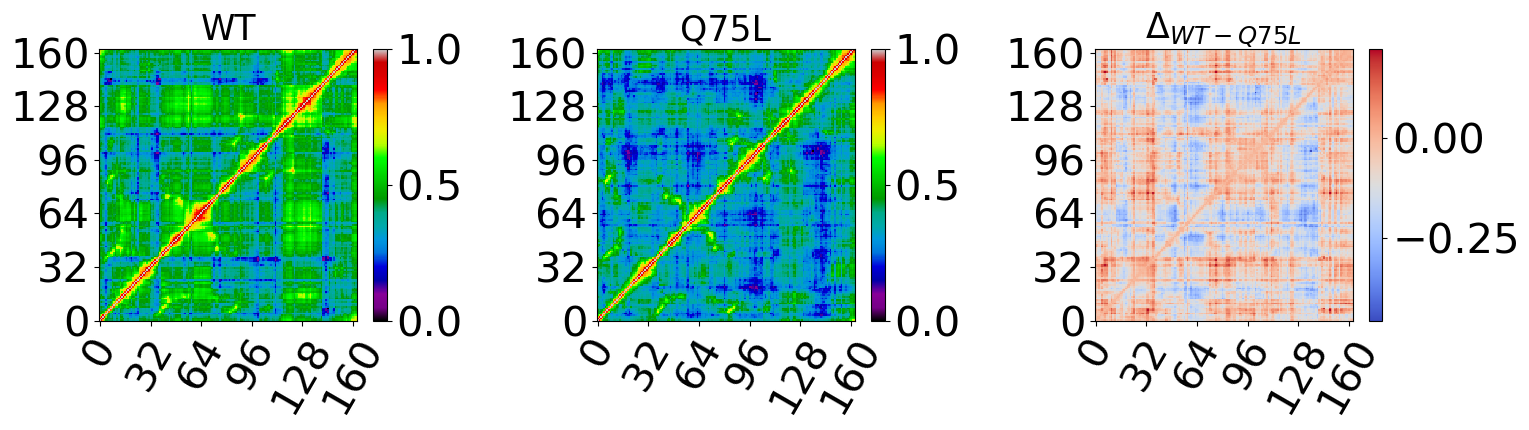

rep. 0
rep. = 0,  RED [ 11  25  33  34  37  38  84 149 153]
rep. = 0,  BLU [ 19  51  57  58  61  64 134 139 141]


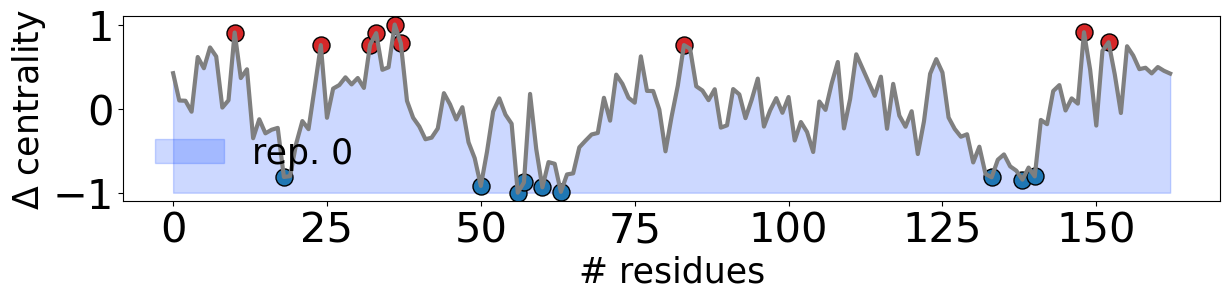

In [31]:
plots = Plots(dyncorrQ75L_load, dyncorrWT_load, matrix_type='gcc_mi', save=rd+'MptpA_ca_MI')
plots.load_parameters({
            'fig': plt.subplots(1, 3, figsize=(16,5)),
            'labels': ['WT', 'Q75L']})
plots.plot_gcc_per_replica()

plots.load_parameters({
            'fig': plt.subplots(1+1,1, figsize=(13,6))})
plots.plot_eigcent_per_replica()

### Compare different correlation metrics

@>: before trimming 26569
@>: after  trimming 26567
@>: before trimming 26567
@>: after  trimming 26565
@>: before trimming 26569
@>: after  trimming 26567
@>: before trimming 26569
@>: after  trimming 26567
@>: before trimming 26567
@>: after  trimming 26565
@>: before trimming 26569
@>: after  trimming 26567


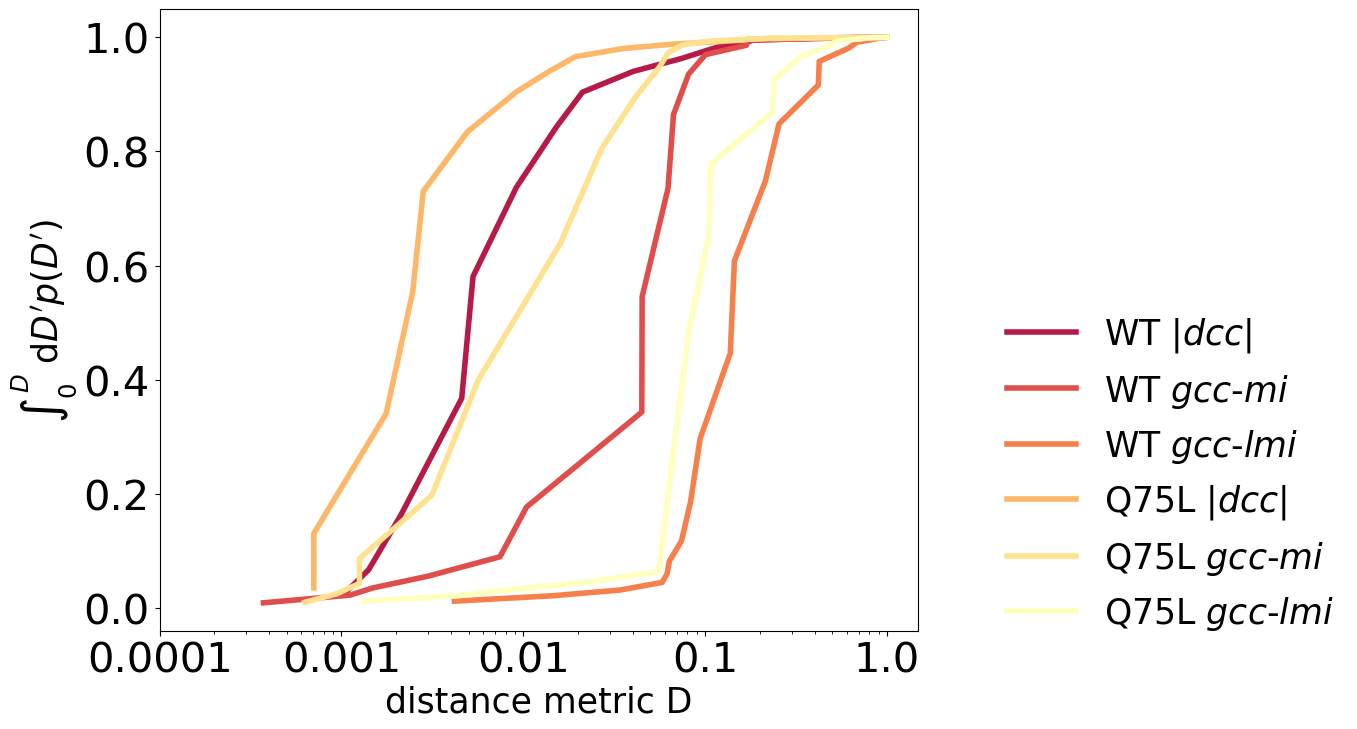

In [32]:
def cdf(data, nbin=20):
    # getting data of the histogram
    count, bins_count = np.histogram(data, bins=nbin)
    # finding the PDF of the histogram using count values
    pdf = count / sum(count)
    # using np.cumsum to calculate the CDF
    cdf = np.cumsum(pdf)
    return cdf, count

def filter_data(input_data):
    data = input_data
    # data = data[data != 1]
    data = data[data != 0]

    data = -np.emath.log(data)
    print('@>: before trimming', len(data))
    data = data[data < np.percentile(data,99.999999)]
    print('@>: after  trimming', len(data))
    return data


bins=20
fig = plt.figure(figsize=(10,8))
colors=sns.color_palette("Spectral", 21)

x = np.asarray([dyncorrWT_load.dcc_allreplicas['rep_%d' %rep] for rep in range(1)]).mean(axis=0).flatten()
y = np.asarray([dyncorrWT_load.gcc_allreplicas['rep_%d' %rep]['gcc_mi'] for rep in range(1)]).mean(axis=0).flatten()
z = np.asarray([dyncorrWT_load.gcc_allreplicas['rep_%d' %rep]['gcc_lmi'] for rep in range(1)]).mean(axis=0).flatten()

i = np.asarray([dyncorrQ75L_load.dcc_allreplicas['rep_%d' %rep] for rep in range(1)]).mean(axis=0).flatten()
j = np.asarray([dyncorrQ75L_load.gcc_allreplicas['rep_%d' %rep]['gcc_mi'] for rep in range(1)]).mean(axis=0).flatten()
k = np.asarray([dyncorrQ75L_load.gcc_allreplicas['rep_%d' %rep]['gcc_lmi'] for rep in range(1)]).mean(axis=0).flatten()

x = filter_data(x)
y = filter_data(y)
z = filter_data(z)
i = filter_data(i)
j = filter_data(j)
k = filter_data(k)


cdf_x, count_x = cdf(x, nbin=bins)
plt.plot(sorted(count_x/max(count_x), reverse=False), cdf_x, label='WT |$dcc$|', lw=4, color=colors[0])

cdf_y, count_y = cdf(y, nbin=bins)
plt.semilogx(sorted(count_y/max(count_y), reverse=False), cdf_y, label='WT $gcc$-$mi$', lw=4, color=colors[2])

cdf_z, count_z = cdf(z, nbin=bins)
plt.semilogx(sorted(count_z/max(count_z), reverse=False), cdf_z, label='WT $gcc$-$lmi$', lw=4, color=colors[4])


cdf_i, count_i = cdf(i, nbin=bins)
plt.semilogx(sorted(count_i/max(count_i), reverse=False), cdf_i, label='Q75L |$dcc$|', lw=4, color=colors[6])


cdf_j, count_j = cdf(j, nbin=bins)
plt.semilogx(sorted(count_j/max(count_j), reverse=False), cdf_j, label='Q75L $gcc$-$mi$', lw=4, color=colors[8])


cdf_k, count_k = cdf(k, nbin=bins)
plt.semilogx(sorted(count_k/max(count_k), reverse=False), cdf_k, label='Q75L $gcc$-$lmi$', lw=4, color=colors[10])

plt.xticks(np.asarray([1e-4,1e-3,1e-2,1e-1,1e-0]), np.asarray([1e-4,1e-3,1e-2,1e-1,1e-0]))
fig.legend(bbox_to_anchor=(1.4,.6), framealpha=False, ncol=1)
plt.xlabel('distance metric D')
plt.ylabel('$\int_0^D$ d$D\'p(D\')$')
plt.savefig(rd + 'MptpA_cumulative_log_log.pdf', bbox_inches='tight')

#**Test Case 2**: Visualize netwkorks

#### save a matrices of interest to npy format for visualization 

In [33]:
np.save(rd + 'Q75L_gccmi.npy',    dyncorrQ75L_load.gcc_allreplicas['rep_0']['gcc_mi'])
np.save(rd + 'Q75L_dgccmi.npy',   dyncorrQ75L_load.dih_gcc_allreplicas['rep_0']['gcc_mi'])
np.save(rd + 'Q75L_ksgcclmi.npy',  dyncorrQ75L_load.KS_DA_LMI_corr_allrep['rep_0']['don_acc'])
np.save(rd + 'WT_gccmi.npy',      dyncorrWT_load.gcc_allreplicas['rep_0']['gcc_mi'])
np.save(rd + 'WT_dgccmi.npy',     dyncorrWT_load.dih_gcc_allreplicas['rep_0']['gcc_mi'])
np.save(rd + 'WT_ksgcclmi.npy',    dyncorrWT_load.KS_DA_LMI_corr_allrep['rep_0']['don_acc'])


In [34]:
from mdigest.utils.pdbhandler import *
from mdigest.core.networkcanvas import *
import pickle as pkl

def to_pickle(dataframe, output):
        pkl.dump(dataframe, open(output, 'wb'))


Aside from saving a png image of the correlation networks of interest we can visualize them and compare interactively. 
Here we apply a threshold to focus only on a subset of edges (for instance those belonging to pairs of residues at a distance below or equal to 5 angstroms).
The upper/lower thresholds can be adapded according to preference. Moreover setting distmat=False  the lower_thr and upper_thr will select values directly from the correlation matrix (hence should be chosent  between 0 and 1).
Negative correlation values (where possible) are taken in absolute value.  


#### Save dataframe to visualize interactively (in pymol) WT MptpA networks

In [35]:
# costumizable actions: if multiple replicas, one can average over a selection, or just take one.
# here we have all trajectorie concatenated in a single one, hence we access each matrix using the `rep_0` key:
   
dist_WT   = np.mean([dyncorrWT_load.distances_allreplicas['rep_%s' %i].copy() for i in range(1)], axis=0)
gcc_WT    = np.mean([dyncorrWT_load.gcc_allreplicas['rep_%s' %i]['gcc_lmi'].copy() for i in range(1)], axis=0)
dgcc_WT   = np.mean([dyncorrWT_load.dih_gcc_allreplicas['rep_%s' %i]['gcc_lmi'].copy() for i in range(1)], axis=0)
ks_gcc_WT = np.mean([dyncorrWT_load.KS_DA_LMI_corr_allrep['rep_%s' %i]['don_acc'].copy() for i in range(1)], axis=0)
matrix_dictionary = {'gcc_WT': gcc_WT, 'dgcc_WT':dgcc_WT,  'ks_gcc_WT': ks_gcc_WT}
vizcorr = ProcCorr()
vizcorr.source_universe(mdsWT.mda_u)
vizcorr.writePDBforframe(0, rd + 'frame0')
vizcorr.set_outputparams({'outdir': rd })
vizcorr.load_matrix_dictionary(matrix_dictionary.copy())
vizcorr.populate_attributes(matrix_dictionary.copy())

vizcorr.set_thresholds(prune_upon=np.asarray(dist_WT.copy()), lower_thr=0, upper_thr=5.)
vizcorr.filter_by_distance(matrixtype='gcc_WT', distmat=True)
vizcorr.filter_by_distance(matrixtype='dgcc_WT', distmat=True)
vizcorr.filter_by_distance(matrixtype='ks_gcc_WT', distmat=True)
vizcorr.to_df(normalize=True)
df_WT = vizcorr.df
to_pickle(df_WT, output= rd + 'network_Ptpa_WT_filter_d_0_5.pkl'.format(0,5))



@> setting gcc_WT attribute
@> setting dgcc_WT attribute
@> setting ks_gcc_WT attribute
@>: lower distance threshold is set to 0
@>: upper distance threshold is set to 5.0
@>: loc_factor is set to None
@>: inv_loc_factor is set to None
Pruning based on distance matrix values
@>: filtering correlations corresponding to inter-residue distances lower than 0 Angstrom and
@>: higher than 5.0 Angstrom
Pruning based on distance matrix values
@>: filtering correlations corresponding to inter-residue distances lower than 0 Angstrom and
@>: higher than 5.0 Angstrom
Pruning based on distance matrix values
@>: filtering correlations corresponding to inter-residue distances lower than 0 Angstrom and
@>: higher than 5.0 Angstrom
@>: apply normalization on gcc_WT column
@>: map gcc_WT column to (0, 1) range
@>: apply normalization on dgcc_WT column
@>: map dgcc_WT column to (0, 1) range
@>: apply normalization on ks_gcc_WT column
@>: map ks_gcc_WT column to (0, 1) range


#### Save dataframe to visualize interactively (in pymol) Q75L MptpA networks

In [36]:
dist_Q75L = np.mean([dyncorrQ75L_load.distances_allreplicas['rep_%s' %i].copy() for i in range(1)], axis=0)
gcc_Q75L = np.mean([dyncorrQ75L_load.gcc_allreplicas['rep_%s' %i]['gcc_lmi'].copy() for i in range(1)], axis=0)
dgcc_Q75L = np.mean([dyncorrQ75L_load.dih_gcc_allreplicas['rep_%s' %i]['gcc_lmi'].copy() for i in range(1)], axis=0)
ks_gcc_Q75L = np.mean([dyncorrQ75L_load.KS_DA_LMI_corr_allrep['rep_%s' %i]['don_acc'].copy() for i in range(1)], axis=0)
matrix_dictionary = {'gcc_Q75L': gcc_Q75L, 'dgcc_Q75L':dgcc_Q75L,  'ks_gcc_Q75L': ks_gcc_Q75L}
vizcorr = ProcCorr()
vizcorr.source_universe(mdsQ75L.mda_u)
vizcorr.writePDBforframe(0, rd + 'frame0')
vizcorr.set_outputparams({'outdir': rd })
vizcorr.load_matrix_dictionary(matrix_dictionary.copy())
vizcorr.populate_attributes(matrix_dictionary.copy())

vizcorr.set_thresholds(prune_upon=np.asarray(dist_Q75L.copy()), lower_thr=0, upper_thr=5.)
vizcorr.filter_by_distance(matrixtype='gcc_Q75L', distmat=True)
vizcorr.filter_by_distance(matrixtype='dgcc_Q75L', distmat=True)
vizcorr.filter_by_distance(matrixtype='ks_gcc_Q75L', distmat=True)
vizcorr.to_df(normalize=True)
df_Q75L = vizcorr.df
to_pickle(df_Q75L, output= rd + 'network_Ptpa_Q75L_filter_d_0_5.pkl'.format(0,5))


@> setting gcc_Q75L attribute
@> setting dgcc_Q75L attribute
@> setting ks_gcc_Q75L attribute
@>: lower distance threshold is set to 0
@>: upper distance threshold is set to 5.0
@>: loc_factor is set to None
@>: inv_loc_factor is set to None
Pruning based on distance matrix values
@>: filtering correlations corresponding to inter-residue distances lower than 0 Angstrom and
@>: higher than 5.0 Angstrom
Pruning based on distance matrix values
@>: filtering correlations corresponding to inter-residue distances lower than 0 Angstrom and
@>: higher than 5.0 Angstrom
Pruning based on distance matrix values
@>: filtering correlations corresponding to inter-residue distances lower than 0 Angstrom and
@>: higher than 5.0 Angstrom
@>: apply normalization on gcc_Q75L column
@>: map gcc_Q75L column to (0, 1) range
@>: apply normalization on dgcc_Q75L column
@>: map dgcc_Q75L column to (0, 1) range
@>: apply normalization on ks_gcc_Q75L column
@>: map ks_gcc_Q75L column to (0, 1) range


In [158]:
# open Pymol locally
from pymol import cmd, util
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
cmd.delete('all')
cmd.bg_color('black')

# place yourself in the `visualize_network` folder
# cd visualize_network
# execute pymol locally calling `pymol` from inside the directory.
# provide path to pdb and data_frame data_frame: change accordingly

path = '/Users/federica/Downloads/mdigest-RESULTS/RESULTS/MptpA/'


cmd.load(path + '1u2p.pdb', '1u2p')
cmd.color('grey80', '1u2p*')
cmd.remove('!(polymer)')
cmd.run('draw_network_pymol.py')
cmd.hide('lines', '*')

cmd.set_view((\
     0.264859468,   -0.952457845,   -0.150496021,\
    -0.843045175,   -0.304483652,    0.443325162,\
    -0.468080193,    0.009453356,   -0.883612871,\
     0.000000000,    0.000000000, -133.785675049,\
     8.123708725,    6.384021759,   22.244569778,\
   105.477645874,  162.093704224,  -20.000000000))

draw_network_from_df(path +'network_Ptpa_Q75L_filter_d_0_5.pkl', which='gcc_Q75L', color_by='gcc_Q75L', sns_palette=sns.color_palette("tab20"), label='gcc_Q75L', edge_norm=1)
draw_network_from_df(path + 'network_Ptpa_WT_filter_d_0_5.pkl',  which='gcc_WT',  color_by='gcc_WT',   sns_palette=sns.color_palette("tab20"), label='gcc_WT',   edge_norm=1)
draw_network_from_df(path +'network_Ptpa_Q75L_filter_d_0_5.pkl', which='dgcc_Q75L', color_by='dgcc_Q75L', sns_palette=sns.color_palette("tab20"), label='dgcc_Q75L', edge_norm=1)
draw_network_from_df(path + 'network_Ptpa_WT_filter_d_0_5.pkl',  which='dgcc_WT',   color_by='dgcc_WT',   sns_palette=sns.color_palette("tab20"), label='dgcc_WT',   edge_norm=1)
draw_network_from_df(path +'network_Ptpa_Q75L_filter_d_0_5.pkl', which='ks_gcc_Q75L', color_by='ks_gcc_Q75L', sns_palette=sns.color_palette("tab20"),  label='ks_gcc_Q75L', edge_norm=1)
draw_network_from_df(path + 'network_Ptpa_WT_filter_d_0_5.pkl',  which='ks_gcc_WT', color_by='ks_gcc_WT',   sns_palette=sns.color_palette("tab20"), label='ks_gcc_WT',   edge_norm=1)



Another interesting analysis is to visualize the change in the strength of the correlation upon perturbation. When normalized measures are used this is equivaent to visualizing the *difference* network. We can color differently positive and negative edges to show the regions that experience an increase/decrease correlations upon perturbation.


In [37]:
# since we have concatenated all replicas in a single trajectory we can access the corresponding matrices using:
df_tot = df_WT.merge(df_Q75L, left_on=df_WT.index, right_on=df_Q75L.index)
df_tot = df_tot.rename(columns={'Source_x':'Source', 'Target_x':'Target'})
to_pickle(df_tot, output= rd + 'network_Ptpa_filter_d_0_5.pkl'.format(0,5))

In [ ]:
# open Pymol locally
from pymol import cmd, util
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
cmd.delete('all')
cmd.bg_color('black')

# place yourself in the `visualize_network` folder
# cd visualize_network
# execute pymol locally calling `pymol` from inside the directory.
# provide path to pdb and data_frame data_frame: change accordingly
 
path = '/Users/federica/Downloads/mdigest-RESULTS/RESULTS/MptpA/'
cmd.load(path + '1u2p.pdb', '1u2p')
cmd.color('grey80', '1u2p*')
cmd.remove('!(polymer)')
cmd.run('draw_network_pymol.py')
cmd.hide('lines', '*')

cmd.set_view((\
     0.264859468,   -0.952457845,   -0.150496021,\
    -0.843045175,   -0.304483652,    0.443325162,\
    -0.468080193,    0.009453356,   -0.883612871,\
     0.000000000,    0.000000000, -133.785675049,\
     8.123708725,    6.384021759,   22.244569778,\
   105.477645874,  162.093704224,  -20.000000000))


draw_network_from_df(path + 'network_Ptpa_filter_d_0_5.pkl', which='gcc_Q75L', w1='gcc_Q75L', w2='gcc_WT', color_sign=True, sns_palette=sns.color_palette("tab20"),          label='gcc_diff', edge_norm=.5)
draw_network_from_df(path + 'network_Ptpa_filter_d_0_5.pkl', which='ks_gcc_Q75L', w1='ks_gcc_Q75L', w2='ks_gcc_WT', color_sign=True, sns_palette=sns.color_palette("tab20"), label='ks_gcc_diff', edge_norm=.5)


# **Test Case 3**: Community Detection
On how to **detect allosteric networks** using molecular dynamics simulation, applied to Imidazole Glycerole Phosphate Synthase (**IGPS**)


## Synopsis

In dynamic networks, a network is said to have community structure if the nodes of the network can be grouped into sets of nodes that are internally well-connected. This topological analysis of protein correlation netwroks (PCNs) can be used to partition the graph in communities and identify the stances of the residues and residue-groups (ensembles of nodes) with influence in the overall allosteric mechanism. 
The community detection starts from a distance network, which  can be constructed from a PCN as d=−log(C), with C being the elements of the correlation matrix that constitute the edges network. MDiGest allows computation of the community structure of PCN through the fast-performing Louvain heuristic scheme, and less efficient but more traditional Girvan-Newman (GN) algorithm (networkcommunities.py module). The Louvain heuristics outperforms the GN method when accounting  for  speed  and  accuracy,  consistently with previously reported analysis, hence should be the preferred choice. The quality of the partitioning is measured through the modularity, where networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. The convergence can be analyzed across multiple runs, or even across different correlation schemes. Just as described for the correlation analysis, resulting community structures can be saved to file for later analysis.


## Import MDiGest Packages

In [39]:
# MDigest packages
import mdigest.core
from mdigest.core.imports import  *
from mdigest.core.parsetrajectory import *
from mdigest.core.correlation import *
from mdigest.core.dcorrelation import *
from mdigest.core.networkcommunities import *
from mdigest.core.networkcanvas import *

from mdigest.core.toolkit import *
from mdigest.core.savedata import *

# accesory packages
from collections import OrderedDict as OD

# For visualization
from pymol import cmd
import nglview    as nv
import ipywidgets as widgets

## Community detection
Here we analyze the community structure underlying the simulated dynamics of Yeast IGPS. 
We verify the stability of the underlying community structure by:
* comparing the communities obtained from **six different replicas** of the *apo* and *PRFAR-bound (holo)* states. 
* comparing the commuinities obtained from **different metrics including** linearized-mutual information based correlation (*gcc*) and dynamical cross correlation (*dcc*) from **C$\alpha$ displacements**  and from **dihedrals fluctuations** (*dgcc*, *ddcc*)), for apo and holo states.


### Set trajectory, topology files and directories for cache and results

In [43]:
# Download the trajectories from
# https://drive.google.com/drive/folders/1XK8X18NJQY-dQUrQaeCGZtSyKeaze5mr?usp=sharing
# change path accordingly: this should be the directory containing the trajectories
trajs = '/Volumes/GoogleDrive-112881197181043313538/Shared drives/PUBLIC/IGPS/'

In [86]:
TOP = {'model1_apo': 'model1_apo.pdb',
       'model3_apo': 'model3_apo.pdb',
       'model4_apo': 'model4_apo.pdb',
       'model5_apo': 'model5_apo.pdb',
       'model6_apo': 'model6_apo.pdb',
       'modela_apo': 'modela_apo.pdb',
       'model1_holo': 'model1_holo_prfar.pdb',
       'model3_holo': 'model3_holo_prfar.pdb',
       'model4_holo': 'model4_holo_prfar.pdb',
       'model5_holo': 'model5_holo_prfar.pdb',
       'model6_holo': 'model6_holo_prfar.pdb',
       'modela_holo': 'modela_holo_prfar.pdb'}

TRAJ = {'model1_apo': 'model1_apo.dcd',
        'model3_apo': 'model3_apo.dcd',
        'model4_apo': 'model4_apo.dcd',
        'model5_apo': 'model5_apo.dcd',
        'model6_apo': 'model6_apo.dcd',
        'modela_apo': 'modela_apo.dcd',
        'model1_holo': 'model1_holo_prfar.dcd',
        'model3_holo': 'model3_holo_prfar.dcd',
        'model4_holo': 'model4_holo_prfar.dcd',
        'model5_holo': 'model5_holo_prfar.dcd',
        'model6_holo': 'model6_holo_prfar.dcd',
        'modela_holo': 'modela_holo_prfar.dcd'}

SYS  = dict(zip(list(TOP.keys()),list(TRAJ.keys())))


# define path to output folder and cache
savedir = currdir + 'mdigest-RESULTS/'
cachedir = savedir + 'CACHE/'
mdigest.core.toolkit.folder_exists(cachedir)
results_dir = savedir + 'RESULTS/IGPS/'
mdigest.core.toolkit.folder_exists(results_dir)
rd = results_dir


# initialize array of colors
colors = cm.get_cmap('tab20').colors
colors = [list(mpl.colors.to_rgb(c)) for c in colors]

### Stride trajectories
Any analysis begins with parsing the trajectories and chosing the appropriate `atom selection` on which the analysis will be run.
Here, we will compare communities obtained from a CA-displacements and from dihedrals (which match the selections below - `protein and name CA` and `protein`.
The TOP and TRAJ dictionaries contain six apo and six holo pdb-dcd pairs. 
By setting the number of replicas as 6 the correlations will be computed independently on each apo/holo trajectory.

In [45]:
mdsAPO = MDS()
# set number of replicas
mdsAPO.set_num_replicas(6) # use 2 if you have 2 replicas.

# load topology and trajectory files into MDS class
mdsAPO.load_system(os.path.join(trajs, "%s" % 'protein.psf'),  [os.path.join(trajs, "%s" %TRAJ[k]) for k,v in TRAJ.items() if 'apo' in k])
# align trajectory
mdsAPO.align_traj(inMemory=True, selection='name CA')
# set selections for MDS class
mdsAPO.set_selection('protein and name CA', 'protein')
# stride trajectory
mdsAPO.stride_trajectory(initial=0, final=-1, step=1)

  0%|          | 0/6000 [00:00<?, ?it/s]

@>: number of frames:      6000
@>: number of replicas:    6
@>: using window length of 1000 simulation steps
@>: number or frames per replica: 1000
@>: first frame:           0
@>: last frame:            6000
@>: step:                  1
@>: number of residues in selected atom group: 552
@>: number of nodes    in selected atom group: 552
@>: number of elements in selected atom group: 552


In [46]:
mdsHOLO = MDS()
# set number of replicas
mdsHOLO.set_num_replicas(6)

# load topology and trajectory files into MDS class
mdsHOLO.load_system(os.path.join(trajs, "%s" % 'protein_prfar.psf'),  [os.path.join(trajs, "%s" %TRAJ[k]) for k,v in TRAJ.items() if 'holo' in k])
# align trajectory
mdsHOLO.align_traj(inMemory=True, selection='name CA')
# set selections for MDS class
mdsHOLO.set_selection('protein and name CA', 'protein')
# stride trajectory 
# the step parameter decides how many frames to keep 
mdsHOLO.stride_trajectory(initial=0, final=-1, step=1)

  0%|          | 0/6000 [00:00<?, ?it/s]

@>: number of frames:      6000
@>: number of replicas:    6
@>: using window length of 1000 simulation steps
@>: number or frames per replica: 1000
@>: first frame:           0
@>: last frame:            6000
@>: step:                  1
@>: number of residues in selected atom group: 552
@>: number of nodes    in selected atom group: 552
@>: number of elements in selected atom group: 552


### Correlation analysis

We compute *lmi-gcc* and *dcc* from dihedrals for apo and holo trajectories using the `DihDynCorr` class. This is done by setting LMI='gaussian', and DCC=True, the remaining flags are set to None. The mean_center=True ensures that the dihedral timeseries is mean centered. 

In [ ]:
%%time
dihdyncorrAPO = DihDynCorr(mdsAPO)
dihdyncorrAPO.parse_dih_dynamics(mean_center=True, LMI='gaussian', MI=None, DCC=True, PCC=None, COV_DISP=None)


In [ ]:
%%time
# compute correlation from dyhedral fluctuations for HOLO trajectories
dihdyncorrHOLO = DihDynCorr(mdsHOLO)
dihdyncorrHOLO.parse_dih_dynamics(mean_center=True, LMI='gaussian', MI=None, DCC=True, PCC=None, COV_DISP=None)


We repeat the calculation of *lmi-gcc* and *dcc*  C$\alpha$ displacements for apo and holo trajectories this time using the `DynCorr` class. 

Here, we include also the computation of the 
`exclusions_matrix` which will be used later for the calculation of communities. 
In practice, to determine which nodes are in contact, the shortest distance  between  heavy  atoms  (all  atoms  excluding  hydrogen atoms) represented by two nodes is calculated. 
Here, we will consider residues to be in contact if their distance is shorter than 4.5 Å in a simulation frame,   and they remain in contact in more than 75% of a simulation.
The `exclusion matrix will then be applied` to filter out the atom that are not in contact.


In [ ]:
dyncorrAPO = DynCorr(mdsAPO)
dyncorrAPO.parse_dynamics(mean_center=True, LMI='gaussian', MI=None, DCC=True, PCC=None, COV_DISP=None)
dyncorrAPO.edge_exclusion(spatial_cutoff=4.5, contact_cutoff=.75, save_name=savedir + '%s' %'apo' )

In [ ]:
dyncorrHOLO = DynCorr(mdsHOLO)
dyncorrHOLO.parse_dynamics(mean_center=True, LMI='gaussian', MI=None, DCC=True, PCC=None, COV_DISP=None)
dyncorrHOLO.edge_exclusion(spatial_cutoff=4.5, contact_cutoff=.75, save_name=savedir + '%s' %'holo' )

The C$\alpha$-based correlation matrices have dimension N $\times$ N, where N=552, corresponding to the number of residues in the system.
Dihedrals-based correlations have dimension N-2 $\times$ N-2, because the first and last residue dont have $\phi$ and $ \psi$ torsional angles. 
In order to be able to compare the two we excude first and last column/rows from the $C\alpha$-based correlation matrices.

In [ ]:
# trick to reduce exclusion matrix size (to match dihedrals correlation shape)
dyncorrAPO_red = dyncorrAPO
dyncorrAPO_red.exclusion_matrix_allreplicas = dict(zip(list(['rep_0','rep_1','rep_2', 'rep_3','rep_4', 'rep_5']),[ dyncorrAPO.exclusion_matrix_allreplicas['rep_%d' %rep][1:-1, 1:-1] for rep in range(6)]))
dyncorrAPO_red.distances_allreplicas = dict(zip(list(['rep_0','rep_1','rep_2', 'rep_3','rep_4', 'rep_5']),[ dyncorrAPO.distances_allreplicas['rep_%d' % rep][1:-1, 1:-1] for rep in range(6)]))

In [ ]:
# trick to reduce exclusion matrix size (to match dihedrals correlation shape)
dyncorrHOLO_red = dyncorrHOLO
dyncorrHOLO_red.exclusion_matrix_allreplicas = dict(zip(list(['rep_0','rep_1','rep_2', 'rep_3','rep_4', 'rep_5']),[ dyncorrHOLO.exclusion_matrix_allreplicas['rep_%d' %rep][1:-1, 1:-1] for rep in range(6)]))
dyncorrHOLO_red.distances_allreplicas = dict(zip(list(['rep_0','rep_1','rep_2', 'rep_3','rep_4', 'rep_5']),[ dyncorrHOLO.distances_allreplicas['rep_%d' % rep][1:-1, 1:-1] for rep in range(6)]))

#### Save correlation analysis

We save the corresponding classes for later use

In [ ]:
dihdyncorrAPO.save_class(file_name_root=savedir + 'IGPS_dihdyncorr_APO')

In [ ]:
dihdyncorrHOLO.save_class(file_name_root=savedir + 'IGPS_dihdyncorr_HOLO')

### Load correlation analysis

In [71]:
# reload attributes of the correlation analysis
APO_corr = sd.MDSdata()
APO_corr.load_from_file(file_name_root=cachedir + 'IGPS_dyncorr_APO', save_space=True)

# double  load trick to have all class attributes from both dyncorr and ks analysis in one
APO_load = APO_corr
APO_load.load_from_file(file_name_root=cachedir + 'IGPS_dihdyncorr_APO')


@>: file '/Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dyncorr_APO_cache.hf' does not extist
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dyncorr_APO_exclusion_matrix_allreplicas.h5
@>: cached file found: loading  /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_APO_cache.hf
@>: atom_group_selstr |S100 () 1
    Done loading atom_group_selstr attribute
@>: dih_indices int64 (550, 2) 1100
    Done loading dih_indices attribute
@>: dih_labels |S10 (4,) 4
    Done loading dih_labels attribute
@>: system_selstr |S100 () 1
    Done loading system_selstr attribute
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_APO_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_APO_nodes_dih_to_indices_dictionary.h5
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_APO_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_APO

In [72]:
# reload attributes of the correlation analysis
HOLO_corr = sd.MDSdata()
HOLO_corr.load_from_file(file_name_root=cachedir + 'IGPS_dyncorr_HOLO', save_space=True)

# double  load trick to have all class attributes from both dyncorr and ks analysis in one

HOLO_load = HOLO_corr
HOLO_load.load_from_file(file_name_root=cachedir + 'IGPS_dihdyncorr_HOLO')


@>: file '/Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dyncorr_HOLO_cache.hf' does not extist
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dyncorr_HOLO_exclusion_matrix_allreplicas.h5
@>: cached file found: loading  /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_HOLO_cache.hf
@>: atom_group_selstr |S100 () 1
    Done loading atom_group_selstr attribute
@>: dih_indices int64 (550, 2) 1100
    Done loading dih_indices attribute
@>: dih_labels |S10 (4,) 4
    Done loading dih_labels attribute
@>: system_selstr |S100 () 1
    Done loading system_selstr attribute
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_HOLO_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_HOLO_nodes_dih_to_indices_dictionary.h5
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdyncorr_HOLO_nodes_to_res_dictionary.h5
@>: load /Users/federica/Downloads/mdigest-RESULTS/CACHE/IGPS_dihdynco

### Prepare community calculation
Finding communities requires:
* the correlation matrix or set of correlation matrices for which to find the underlying community structure,
* the `exclusions_matrix/`, defines the sparsity of the graph for which communities are computed, by setting which nodes are considered to be in contact for the purposes of network analysis. 
Alternatively one may direclty use the `distance_matrix`,
and keep the residue pairs that are below a certain threshold. The latter procedure is faster as it doesn't require computation of the `exclusion_matrix`, which tends to be more precise, as it takes into account all heavy atoms to define if any two residues are in contact). In the case a selection based on the distance_matrix is chosen we recommend using a sligly larger cutoff (5 Å)

In [73]:
# load dictionaries
cmtyl=CMTY()
matrix_dictionary = OD({
                        'model0_apo': APO_load.dih_gcc_allreplicas['rep_0']['gcc_lmi'],
                        'model1_apo': APO_load.dih_gcc_allreplicas['rep_1']['gcc_lmi'],
                        'model2_apo': APO_load.dih_gcc_allreplicas['rep_2']['gcc_lmi'],
                        'model3_apo': APO_load.dih_gcc_allreplicas['rep_3']['gcc_lmi'],
                        'model4_apo': APO_load.dih_gcc_allreplicas['rep_4']['gcc_lmi'],
                        'model5_apo': APO_load.dih_gcc_allreplicas['rep_5']['gcc_lmi'],
                       'model0_holo': HOLO_load.dih_gcc_allreplicas['rep_0']['gcc_lmi'],
                       'model1_holo': HOLO_load.dih_gcc_allreplicas['rep_1']['gcc_lmi'],
                       'model2_holo': HOLO_load.dih_gcc_allreplicas['rep_2']['gcc_lmi'],
                       'model3_holo': HOLO_load.dih_gcc_allreplicas['rep_3']['gcc_lmi'],
                       'model4_holo': HOLO_load.dih_gcc_allreplicas['rep_4']['gcc_lmi'],
                       'model5_holo': HOLO_load.dih_gcc_allreplicas['rep_5']['gcc_lmi']})
cmtyl.create_matrix_dict(matrix_dictionary=matrix_dictionary)
filters_dictionary = OD({'exclusion_matrix':OD({
                        'model0_apo': APO_load.exclusion_matrix_allreplicas['rep_0'],
                        'model1_apo': APO_load.exclusion_matrix_allreplicas['rep_1'],
                        'model2_apo': APO_load.exclusion_matrix_allreplicas['rep_2'],
                        'model3_apo': APO_load.exclusion_matrix_allreplicas['rep_3'],
                        'model4_apo': APO_load.exclusion_matrix_allreplicas['rep_4'],
                        'model5_apo': APO_load.exclusion_matrix_allreplicas['rep_5'],
                       'model0_holo': HOLO_load.exclusion_matrix_allreplicas['rep_0'],
                       'model1_holo': HOLO_load.exclusion_matrix_allreplicas['rep_1'],
                       'model2_holo': HOLO_load.exclusion_matrix_allreplicas['rep_2'],
                       'model3_holo': HOLO_load.exclusion_matrix_allreplicas['rep_3'],
                       'model4_holo': HOLO_load.exclusion_matrix_allreplicas['rep_4'],
                       'model5_holo': HOLO_load.exclusion_matrix_allreplicas['rep_5']}),

                        })


### Generate communities through Louvain approach
Here we generate communities separately for the 12 apo and holo simulation replicas.
The `aggregate=True` ensures communities smaller than 5 are redistributed (accoriding to maximum modularity).  

In [74]:
cmtyl.populate_filters(filters_dictionary=filters_dictionary) 
filters = {'exclusion': True} # distance set to False
cmtyl.assign_filters(filters=filters)
cmtyl.load_graph()

# Alternatively, using distance matrix rather than exclusion
# cmtyl.populate_filters(filters_dictionary=filters_dictionary) 
# filters = {'exclusion': False, 'distance': True} # distance set to False
# cmtyl.assign_filters(filters=filters)
# cmtyl.load_graph(distance_threshold=5)


parameters = {'VERBOSE': False, 'LOUVAIN_ITERATIONS':20}
cmtyl.set_parameters(parameters)
cmtyl.run_cmtys_louvain(aggregate=True, threshold=5) # adapt the number to select the minimum 
                                           # size of the resulting communities. Suggested 5 or lower.


processing model0_apo ...
@>: there are 3660 nonzero elements in this matrix
@>: graph has 1830 edges
processing model1_apo ...
@>: there are 3532 nonzero elements in this matrix
@>: graph has 1766 edges
processing model2_apo ...
@>: there are 3526 nonzero elements in this matrix
@>: graph has 1763 edges
processing model3_apo ...
@>: there are 3524 nonzero elements in this matrix
@>: graph has 1762 edges
processing model4_apo ...
@>: there are 3570 nonzero elements in this matrix
@>: graph has 1785 edges
processing model5_apo ...
@>: there are 3472 nonzero elements in this matrix
@>: graph has 1736 edges
processing model0_holo ...
@>: there are 3598 nonzero elements in this matrix
@>: graph has 1799 edges
processing model1_holo ...
@>: there are 3546 nonzero elements in this matrix
@>: graph has 1773 edges
processing model2_holo ...
@>: there are 3454 nonzero elements in this matrix
@>: graph has 1727 edges
processing model3_holo ...
@>: there are 3456 nonzero elements in this matrix
@

In [75]:
# this is the number of different instances (correlation matrices obtained from each apo-holo replica) for which we are going to calculate the communities for
cmtyl.num_instances

12

#### Plot consensus communities for each trajectory

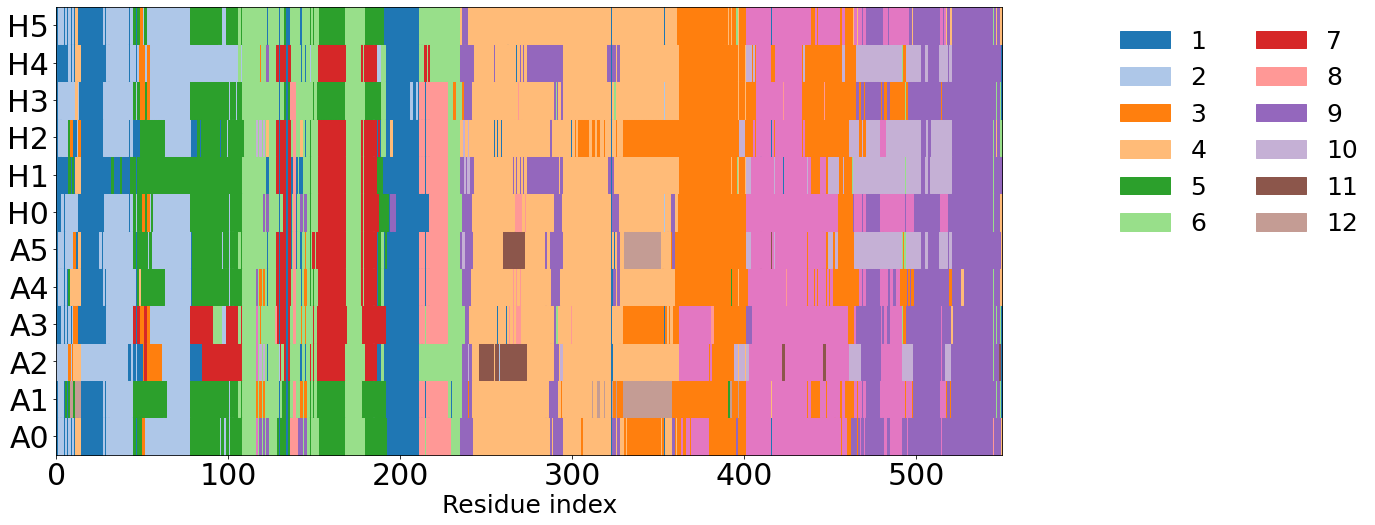

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_xlabel('Residue index')

community_colors_cdict = []

for y in cmtyl.nodes_communities_collect.keys():
    tmp = {}
    for commkey, comm in cmtyl.nodes_communities_collect[y]['comm_nodes'].items():
        for key in comm:
            ax.fill_between([key, key + 1], y + 1, y, color=colors[cmtyl.nodes_communities_collect[y]['color_index'][cmtyl.partitions_collect[y][key]]])
            tmp.update({commkey:colors[cmtyl.nodes_communities_collect[y]['color_index'][cmtyl.partitions_collect[y][key]]]})
    community_colors_cdict.append(tmp)
        
ax.set_ylim(0,cmtyl.num_instances)
ax.set_xlim(0,550)

tot = np.max(np.concatenate(np.asarray([cmtyl.nodes_communities_collect[i]['comm_labels'] for i in range(len(cmtyl.nodes_communities_collect))], dtype=object)))

for c in range(tot):
    ax.axvspan(-1,-2,-1,-2, color=colors[c], label=c+1)

ax.legend(bbox_to_anchor=(1.4,1), ncol=2, framealpha=False)
ax.set_yticks(np.arange(0.5,12.5,1))
ax.set_yticklabels(['A0','A1','A2','A3','A4','A5','H0','H1','H2','H3','H4','H5'])

plt.savefig(rd + 'louvain_AHcorrelation_12rep.pdf', facecolor=fig.get_facecolor())
plt.show()

We can see that holo and apo trajectories share some patterns but with evident changes across the different replicas. 

This is just another observation of the fact that free energy landscape of  simulations is often rugged, and minor differences in the initial velocities, or initial structure can yield very different in terms of the sampled landscape. 

This is why it appears that a good rule of thumb is to perform a minimum of 3 to 10 replicas and average the analysis over the different runs.

#### Difference communities

A way to determine how different are apo and holo trajectories is to check whether PRFAR produces a similar effect across the different independent runs.
Here we started 6 independent apo runs, and added PRFAR on each equilibrated structure, hence it is reasonable to check compare the communities generated from each independent pair of apo-holo  trajectories.

To do so, we generate communities using the different linearized mutual information  based correlation matrix calculated from dihedral fluctuations.
Again we apply the `exclusion_matrix` to select the elements of the correlation that correspond to residues that are in at a distance < 4.5 Å for more than 75 % of the frame.
Since we have two trajectories we take the average `exclusion_matrix` (rounded to integers).


In [ ]:
cmtyl_diff=CMTY()
n=550
matrix_dictionary = OD({'model0': HOLO_load.dih_gcc_allreplicas['rep_0']['gcc_lmi'] - APO_load.dih_gcc_allreplicas['rep_0']['gcc_lmi'],
                        'model1': HOLO_load.dih_gcc_allreplicas['rep_1']['gcc_lmi'] - APO_load.dih_gcc_allreplicas['rep_1']['gcc_lmi'],
                        'model2': HOLO_load.dih_gcc_allreplicas['rep_2']['gcc_lmi'] - APO_load.dih_gcc_allreplicas['rep_2']['gcc_lmi'],
                        'model3': HOLO_load.dih_gcc_allreplicas['rep_3']['gcc_lmi'] - APO_load.dih_gcc_allreplicas['rep_3']['gcc_lmi'],
                        'model4': HOLO_load.dih_gcc_allreplicas['rep_4']['gcc_lmi'] - APO_load.dih_gcc_allreplicas['rep_4']['gcc_lmi'],
                        'model5': HOLO_load.dih_gcc_allreplicas['rep_5']['gcc_lmi'] - APO_load.dih_gcc_allreplicas['rep_5']['gcc_lmi']})

cmtyl_diff.create_matrix_dict(matrix_dictionary=matrix_dictionary)
filters_dictionary = OD({'exclusion_matrix':OD({
        'model0': np.round(np.mean([HOLO_load.exclusion_matrix_allreplicas['rep_0'], APO_load.exclusion_matrix_allreplicas['rep_0']], axis=0),0).flatten().astype(bool).reshape((n,n)),
        'model1': np.round(np.mean([HOLO_load.exclusion_matrix_allreplicas['rep_1'], APO_load.exclusion_matrix_allreplicas['rep_1']], axis=0),0).flatten().astype(bool).reshape((n,n)),
        'model2': np.round(np.mean([HOLO_load.exclusion_matrix_allreplicas['rep_2'], APO_load.exclusion_matrix_allreplicas['rep_2']], axis=0),0).flatten().astype(bool).reshape((n,n)),
        'model3': np.round(np.mean([HOLO_load.exclusion_matrix_allreplicas['rep_3'], APO_load.exclusion_matrix_allreplicas['rep_3']], axis=0),0).flatten().astype(bool).reshape((n,n)),
        'model4': np.round(np.mean([HOLO_load.exclusion_matrix_allreplicas['rep_4'], APO_load.exclusion_matrix_allreplicas['rep_4']], axis=0),0).flatten().astype(bool).reshape((n,n)),
        'model5': np.round(np.mean([HOLO_load.exclusion_matrix_allreplicas['rep_5'], APO_load.exclusion_matrix_allreplicas['rep_5']], axis=0),0).flatten().astype(bool).reshape((n,n)),
        }),
     })

cmtyl_diff.populate_filters(filters_dictionary=filters_dictionary)
#filters = {'filter_all': True}
filters = {'exclusion': True}
cmtyl_diff.assign_filters(filters=filters)
cmtyl_diff.load_graph()
parameters = {'VERBOSE': False, 'LOUVAIN_ITERATIONS':10}
cmtyl_diff.set_parameters(parameters)
cmtyl_diff.run_cmtys_louvain(aggregate=True)

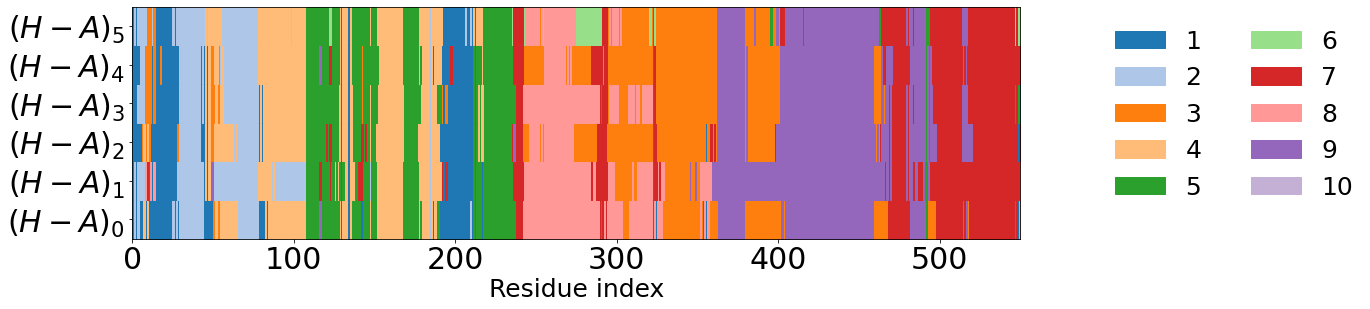

In [ ]:
f, ax = plt.subplots(figsize=(20, 5))

ax.set_xlabel('Residue index')

community_colors_cdict = []

for y in cmtyl_diff.nodes_communities_collect.keys():
    tmp = {}
    for commkey, comm in cmtyl_diff.nodes_communities_collect[y]['comm_nodes'].items():
        for key in comm:
            ax.fill_between([key, key + 1], y + 1, y, color=colors[cmtyl_diff.nodes_communities_collect[y]['color_index'][cmtyl_diff.partitions_collect[y][key]]])
            tmp.update({commkey:colors[cmtyl_diff.nodes_communities_collect[y]['color_index'][cmtyl_diff.partitions_collect[y][key]]]})
    community_colors_cdict.append(tmp)

ax.set_ylim(0,cmtyl_diff.num_instances)
ax.set_xlim(0,550)

tot = np.max(np.concatenate(np.asarray([cmtyl_diff.nodes_communities_collect[i]['comm_labels'] for i in range(len(cmtyl_diff.nodes_communities_collect))], dtype=object)))

for c in range(tot):
    ax.axvspan(-1,-2,-1,-2, color=colors[c], label=c+1)

ax.legend(bbox_to_anchor=(1.4,1), ncol=2, framealpha=False)
ax.set_yticks(np.arange(0.5,6.5,1))
ax.set_yticklabels(['$(H-A)_0$','$(H-A)_1$','$(H-A)_2$','$(H-A)_3$','$(H-A)_4$','$(H-A)_5$'])
plt.savefig(savedir + 'louvain_diff.pdf', facecolor=f.get_facecolor())
plt.show()

overall there is good consensus between the different replicas

In [ ]:
# plot the communities on the protein structure
data_folder = trajs
view = (\
    -0.611808956,   -0.140187785,    0.778481722,\
     0.387945682,    0.804496109,    0.449760556,\
    -0.689334452,    0.577175796,   -0.437813699,\
     0.000000000,    0.000000000, -219.895217896,\
    45.563232422,   57.541908264,   47.740921021,\
    85.014022827,  354.776367188,   20.000000000 )

for i, (k,v) in enumerate(cmtyl_diff.nodes_communities_collect.items()):
    community_lookup = v
    display_community(data_folder, 'model1_apo', view, community_lookup, 
                      community_colors_cdict[i], rd + 'holo-minus-apo_%d' %i )


### Comparison of communities obtained from different metrics and features
Here we compute communities for different metrics (C$\alpha$ and dihedrals) using two different metrics: linearize-mutual information based correlation (gcc) and dynamical cross correlation dcc.

In [ ]:
# apply louvain algorithm
cmtyl_ave=CMTY()

matrix_dictionary = {'CA_GCC_A':  np.mean(np.asarray([APO_load.gcc_allreplicas['rep_%d' %rep]['gcc_lmi'] for rep in range(6)]), axis=0)[1:-1,1:-1],
                     'CA_DCC_A':  np.mean(np.asarray([APO_load.dcc_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0)[1:-1,1:-1],
                     'DIH_GCC_A': np.mean(np.asarray([APO_load.dih_gcc_allreplicas['rep_%d' %rep]['gcc_lmi'] for rep in range(6)]), axis=0),
                     'DIH_DCC_A': np.mean(np.asarray([APO_load.dih_dcc_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                     'CA_GCC_H':  np.mean(np.asarray([HOLO_load.gcc_allreplicas['rep_%d' %rep]['gcc_lmi'] for rep in range(6)]), axis=0)[1:-1,1:-1],
                     'CA_DCC_H':  np.mean(np.asarray([HOLO_load.dcc_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0)[1:-1,1:-1],
                     'DIH_GCC_H': np.mean(np.asarray([HOLO_load.dih_gcc_allreplicas['rep_%d' %rep]['gcc_lmi'] for rep in range(6)]), axis=0),
                     'DIH_DCC_H': np.mean(np.asarray([HOLO_load.dih_dcc_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0)
                     }

cmtyl_ave.create_matrix_dict(matrix_dictionary=matrix_dictionary)
filters_dictionary = {'exclusion_matrix': { 'CA_GCC_A':  np.round(np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            'CA_DCC_A':  np.round(np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            'DIH_GCC_A': np.round(np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            'DIH_DCC_A': np.round(np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            'CA_GCC_H':  np.round(np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            'CA_DCC_H':  np.round(np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            'DIH_GCC_H': np.round(np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            'DIH_DCC_H': np.round(np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),0),
                                            },
                       'distance_matrix': {
                                           'CA_GCC_A':  np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                                           'CA_DCC_A':  np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                                           'DIH_GCC_A': np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                                           'DIH_DCC_A': np.mean(np.asarray([APO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                                           'CA_GCC_H':  np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                                           'CA_DCC_H':  np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                                           'DIH_GCC_H': np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                                           'DIH_DCC_H': np.mean(np.asarray([HOLO_load.exclusion_matrix_allreplicas['rep_%d' %rep] for rep in range(6)]), axis=0),
                        }}

cmtyl_ave.populate_filters(filters_dictionary=filters_dictionary)
filters = {'exclusion': True}
cmtyl_ave.assign_filters(filters=filters)
cmtyl_ave.load_graph()

parameters = {'VERBOSE': False, 'LOUVAIN_ITERATIONS':20}
cmtyl_ave.set_parameters(parameters)
cmtyl_ave.run_cmtys_louvain(aggregate=True)


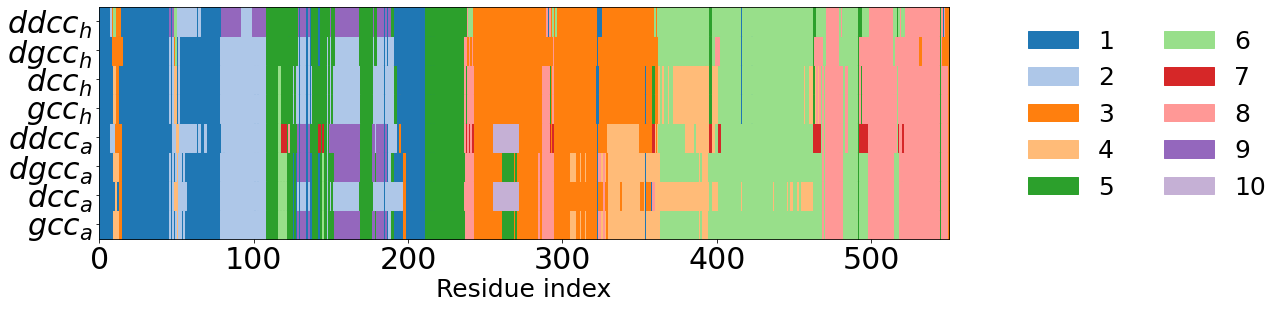

In [72]:
#### Display the communities structure
f, ax = plt.subplots(figsize=(20, 5))

ax.set_xlabel('Residue index')

community_colors_cdict = []

for y in cmtyl_ave.nodes_communities_collect.keys():
    tmp = {}
    for commkey, comm in cmtyl_ave.nodes_communities_collect[y]['comm_nodes'].items():
        for key in comm:
            ax.fill_between([key, key + 1], y + 1, y, color=colors[cmtyl_ave.nodes_communities_collect[y]['color_index'][cmtyl_ave.partitions_collect[y][key]]])
            tmp.update({commkey:colors[cmtyl_ave.nodes_communities_collect[y]['color_index'][cmtyl_ave.partitions_collect[y][key]]]})
    community_colors_cdict.append(tmp)

ax.set_ylim(0,cmtyl_ave.num_instances)
ax.set_xlim(0,550)

tot = np.max(np.concatenate(np.asarray([cmtyl_ave.nodes_communities_collect[i]['comm_labels'] for i in range(1)], dtype=object)))

for c in range(tot):
    ax.axvspan(-1,-2,-1,-2, color=colors[c], label=c+1)

ax.legend(bbox_to_anchor=(1.4,1), ncol=2, framealpha=False)
ax.set_yticks(np.arange(.5,8.5,1))
ax.set_yticklabels(['$gcc_a$','$dcc_a$', '$dgcc_a$', '$ddcc_a$', '$gcc_h$', '$dcc_h$','$dgcc_h$', '$ddcc_h$' ])
plt.savefig(rd + 'gcc_dggc_dcc_ddcc_correlation_apo.pdf', facecolor=f.get_facecolor())
plt.show()


In [84]:
# project communities on the protein secondary structure
data_folder = trajs
outpath = rd
view = (\
    -0.611808956,   -0.140187785,    0.778481722,\
     0.387945682,    0.804496109,    0.449760556,\
    -0.689334452,    0.577175796,   -0.437813699,\
     0.000000000,    0.000000000, -219.895217896,\
    45.563232422,   57.541908264,   47.740921021,\
    85.014022827,  354.776367188,   20.000000000 )

label= ['mean_gcc_a','mean_dcc_a', 'mean_dgcc_a', 'mean_ddcc_a','mean_gcc_h', 'mean_dcc_h', 'mean_dgcc_h' , 'mean_ddcc_h' ]
colors = cm.get_cmap('tab20').colors
colors = [list(mpl.colors.to_rgb(c)) for c in colors]

for i, (k,v) in enumerate(cmtyl_ave.nodes_communities_collect.items()):
    print("Imaging %s" %k)
    community_lookup = v
    display_community(data_folder, 'model1_apo', view, community_lookup, community_colors_cdict[i], outpath + label[i])


Imaging 0
@>: RAYTRACE
Imaging 1
@>: RAYTRACE
Imaging 2
@>: RAYTRACE
Imaging 3
@>: RAYTRACE
Imaging 4
@>: RAYTRACE
Imaging 5
@>: RAYTRACE
Imaging 6
@>: RAYTRACE
Imaging 7
@>: RAYTRACE


In [74]:
# save the communities
cmtyl_ave.save_class(file_name_root=rd + 'IGPS_cmty_ave', save_space=True)

In [75]:
cmtyl_ave_load = sd.MDSdata()
cmtyl_ave_load.load_from_file(file_name_root=rd + 'IGPS_cmty_ave')

@>: cached file found: loading  /content/drive/MyDrive/Federica/MDiGest/MDiGest-notebooks/RESULTS/IGPS/IGPS_cmty_ave_cache.hf
@>: max_direct_distance float64 (1,) 1
    Done loading max_direct_distance attribute
@>: max_distance float64 (1,) 1
    Done loading max_distance attribute
@>: load /content/drive/MyDrive/Federica/MDiGest/MDiGest-notebooks/RESULTS/IGPS/IGPS_cmty_ave_nodesComm.h5
@>: load /content/drive/MyDrive/Federica/MDiGest/MDiGest-notebooks/RESULTS/IGPS/IGPS_cmty_ave_partitions_collect.h5
@>: load /content/drive/MyDrive/Federica/MDiGest/MDiGest-notebooks/RESULTS/IGPS/IGPS_cmty_ave_distances_collect.h5


#### Optimal pathways

The  dynamical  network  models  of  allostery  can  identify optimal  and  suboptimal  allosteric  pathways.   The  statistical distribution of these pathways are useful for locating accessible residues that can work as allosteric regulators of important drug targets.  

Here, we use the Floyd-Warshall algorithm (as implemented in networkx), to find the optimal and suboptimal pathways connecting the glutaminase and cyclase enzymatic domains in IGPS. 

In [91]:
# Uncomment if running in colab
# from google.colab import output
# output.enable_custom_widget_manager()

In [73]:
cmtyl_ave.calculate_betweenness()
cmtyl_ave.compute_optimal_paths()

We retrieve the path between each residue in contact with PRFAR along the simulations and the CYS83 in the active site. 
We use instance=2 and 6 to compute the pathways correaponding to apo and holo trajectories, computed from dihedrals linearized-generalized correlation coefficient matrices *`dgcc`* matrices from apo and holo trajectories.

 


In [93]:
# lets visualize the paths on the protein
# we print the paths and copy the optut in the cell below 

paths = [
cmtyl_ave.retrieve_path(83,334, instance=2),
cmtyl_ave.retrieve_path(83,365, instance=2),
cmtyl_ave.retrieve_path(83,404, instance=2),
cmtyl_ave.retrieve_path(83,469, instance=2),
cmtyl_ave.retrieve_path(83,475, instance=2),
cmtyl_ave.retrieve_path(83,502, instance=2),
cmtyl_ave.retrieve_path(83,524, instance=2),
cmtyl_ave.retrieve_path(83,523, instance=2),
cmtyl_ave.retrieve_path(83,334, instance=6),
cmtyl_ave.retrieve_path(83,365, instance=6),
cmtyl_ave.retrieve_path(83,404, instance=6),
cmtyl_ave.retrieve_path(83,469, instance=6),
cmtyl_ave.retrieve_path(83,475, instance=6),
cmtyl_ave.retrieve_path(83,502, instance=6),
cmtyl_ave.retrieve_path(83,524, instance=6),
cmtyl_ave.retrieve_path(83,523, instance=6)
]
paths



[[83, 47, 49, 391, 345, 347, 334],
 [83, 47, 49, 391, 388, 385, 365],
 [83, 47, 49, 392, 396, 398, 465, 467, 402, 404],
 [83, 47, 49, 392, 396, 398, 465, 467, 469],
 [83, 47, 191, 142, 122, 234, 236, 510, 506, 500, 475],
 [83, 47, 191, 142, 122, 234, 236, 510, 506, 502],
 [83, 47, 191, 142, 291, 240, 524],
 [83, 47, 191, 142, 291, 293, 241, 521, 523],
 [83, 45, 5, 12, 353, 350, 305, 334],
 [83, 47, 54, 50, 390, 387, 385, 365],
 [83, 47, 82, 49, 393, 396, 398, 400, 402, 404],
 [83, 47, 82, 49, 393, 396, 398, 400, 402, 469],
 [83, 81, 191, 144, 120, 237, 518, 509, 505, 475],
 [83, 81, 190, 142, 291, 238, 506, 502],
 [83, 81, 191, 194, 323, 289, 284, 524],
 [83, 81, 190, 142, 291, 238, 534, 523]]

To visualize the pathways open pymol and copy the lines below in the command bar:
apo pathways are shown in blue, holo in red. 
 

In [ ]:
# display paths apo/holo from selected model 
# open pymol and copy the lines below 
workDir = '/Volumes/GoogleDrive-112881197181043313538/Shared drives/PUBLIC/IGPS'

cmd.delete('all')
cmd.bg_color('black')
cmd.load(workDir + 'model1_holo_prfar.pdb', 'yeast')
cmd.color('grey80', 'yeast*')
cmd.remove('!(polymer or resname MOL)')

# load the draw network file 
cmd.run('draw_network_pymol.py')
cmd.hide('lines', '*')
cmd.show('sphere', 'resname MOL')
util.cnc('resname MOL')

cmd.set_view((\
    -0.706806719,    0.257756531,    0.658773422,\
     0.506590307,    0.834414065,    0.217052221,\
    -0.493740588,    0.487141132,   -0.720352232,\
     0.000316544,   -0.000720128, -201.240234375,\
    45.806560516,   58.601139069,   48.244060516,\
  -15052.089843750, 15454.586914062,   20.000000000))

paths=[[83, 47, 49, 391, 345, 347, 334], [83, 47, 49, 391, 388, 385, 365], [83, 47, 49, 392, 396, 398, 465, 467, 402, 404], [83, 47, 49, 392, 396, 398, 465, 467, 469], [83, 47, 191, 142, 122, 234, 236, 510, 506, 500, 475], [83, 47, 191, 142, 122, 234, 236, 510, 506, 502], [83, 47, 191, 142, 291, 240, 524], [83, 47, 191, 142, 291, 293, 241, 521, 523], [83, 45, 5, 12, 353, 350, 305, 334], [83, 47, 54, 50, 390, 387, 385, 365], [83, 47, 82, 49, 393, 396, 398, 400, 402, 404], [83, 47, 82, 49, 393, 396, 398, 400, 402, 469], [83, 81, 191, 144, 120, 237, 518, 509, 505, 475], [83, 81, 190, 142, 291, 238, 506, 502], [83, 81, 191, 194, 323, 289, 284, 524], [83, 81, 190, 142, 291, 238, 534, 523]]

n = int(len(paths/2))
label_list=['apo']*n+['holo']*n
color_list=[(0,0,1)]*n+[(1,0,0)]*n
weight_list=[.7]*n+ [.7]*n
draw_shortest_path(paths, weights_list=weight_list, 
                   colors_list=color_list, labels_list=label_list)

An alernative way to visualize the pathways is shown below using nglview

In [92]:
####
# Plot the 30 highest betweennesses (edges most used by optimal paths)
# This cell does not always run in colab.
####
u = mda.Universe(workDir + TOP['model1_holo'], workDir + TRAJ['model1_holo'])
w = nv.show_mdanalysis(u.select_atoms("all"))
w._remote_call("setSize", target="Widget", args=["800px", "600px"])

w.clear_representations()
w.add_cartoon("protein")
w.add_hyperball("not protein")

w.add_representation(repr_type='licorice', 
                     selection='[res 84]',
                     radius=0.5)

dist = np.mean([APO_load.distances_allreplicas['rep_%d' %rep] for rep in range(6)], axis=0)
replica = 0
for k,v in itertools.islice(cmtyl_ave.betweenness[replica].items(),30):
    display_shortes_path(w, get_path(k[0], k[1],  mdsAPO.mda_u.select_atoms('resid 2-551 and name CA'), cmtyl_ave.predecessors),
             dist, cmtyl_ave.max_direct_distance, mdsAPO.mda_u.select_atoms('resid 2-551 and name CA'), replica,
                        color='blue')

dist = np.mean([HOLO_load.distances_allreplicas['rep_%d' %rep] for rep in range(6)], axis=0)
replica = 0
for k,v in itertools.islice(cmtyl_ave.betweenness[replica].items(),30):
    display_shortes_path(w, get_path(k[0], k[1],  mdsHOLO.mda_u.select_atoms('resid 2-551 and name CA'), cmtyl_ave.predecessors),
             dist, cmtyl_ave.max_direct_distance, mdsHOLO.mda_u.select_atoms('resid 2-551 and name CA'), replica,
                        color='red')
w

NGLWidget(max_frame=999)

#**Test Case 4:** Dimesionality Reduction

In [76]:
import mdigest.core.dimreduction as dimred
from mdigest.core.plots import dim_reduction_plots as DimRedPlots
import seaborn as sns
import MDAnalysis as mda
import mdtraj as md
import numpy as np

In [87]:
# define trajectory and topology files
parent = '/Volumes/GoogleDrive-112881197181043313538/Shared drives/PUBLIC/MptpA/'

# define trajectory files
topology_WT     = parent + 'dry_1U2P.psf'
topology_Q75L   = parent + 'dry_1U2P_Q75L.psf'
trajectory_WT   = [ parent + 'dry_1U2P_2_200ns.dcd', parent + 'dry_1U2P_3_200ns.dcd', parent + 'dry_1U2P_4_200ns.dcd']
trajectory_Q75L = [ parent + 'dry_1U2P_Q75L_2_200ns.dcd', parent + 'dry_1U2P_Q75L_3_200ns.dcd', parent + 'dry_1U2P_Q75L_4_200ns.dcd']


# define trajectory files
DR = dimred.DimReduct()
traj_dict = {'WT'  :  [ parent + 'dry_1U2P_2_200ns.dcd', parent + 'dry_1U2P_3_200ns.dcd', parent + 'dry_1U2P_4_200ns.dcd'],
             'Q75L':  [ parent + 'dry_1U2P_Q75L_2_200ns.dcd', parent + 'dry_1U2P_Q75L_3_200ns.dcd', parent + 'dry_1U2P_Q75L_4_200ns.dcd']}
top_dict = {'WT':  parent + 'dry_1U2P.psf',
            'Q75L': parent + 'dry_1U2P_Q75L.psf'}

feat_dict = {'WT': {'select':'resSeq 1 to 163 and name C CA N O'},
             'Q75L': {'select':'resSeq 1 to 163 and name C CA N O'},
             }

DR.set_parameter_dictionary(traj_dict, top_dict, feat_dict)



In [88]:
reference = md.load(parent + 'dry_1U2P_2_200ns.dcd', top=topology_WT)

DR.load_data(load_from='from_dictionaries',align=True, reference=reference)
DR.dimReduction(method='PCA', projection=True, **{'project_on': range(0,2)})
params =  {'universe'  : mda.Universe(top_dict['WT'], traj_dict['WT']),
            'selection': 'resSeq 1 to 163 and name C CA N O',
            'outdir'   : savedir,
            'outname'  : 'projected_traj'}
DR.write_proj_trajectory('WT', **params)

@>: loading data from dictionaries
@>: aligning trajectory...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2465 atoms, 163 residues, and unitcells>...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2465 atoms, 163 residues, and unitcells>...
@>: apply z_score to data
@>: compute pca
@>: fit transform
@>: project trajectory onto selected components
@>: components [0, 1] are selected for projection
@>: store selected eigenvectors
@>: store transformed coord
@>: fitted transformed coordinates have shape (30000, 10)
@>: project transformed coordinates
@>: total variance described by selected components 0.408053906616227


2


IsADirectoryError: [Errno 21] Is a directory: '/Users/federica/Downloads/mdigest-RESULTS/'

<Figure size 2000x2000 with 0 Axes>

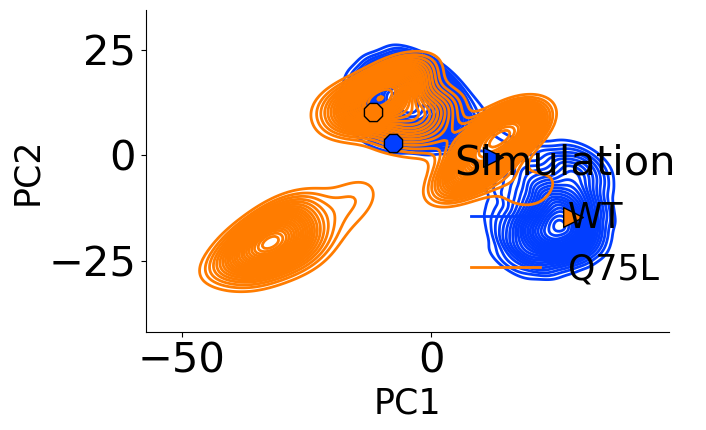

In [89]:
label = np.asarray(['WT']*15000+['Q75L']*15000)
DimRedPlots.plot_pca_space(DR.fitted_transformed, label , 'WT',
                           rd, levels=30,
                          colors=sns.color_palette("bright", 2))

In [91]:
reference = md.load(parent + 'dry_1U2P_2_200ns.dcd', top=topology_WT)
DR_WT = dimred.DimReduct()
traj_dict_WT = {'WT_0': parent + 'dry_1U2P_2_200ns.dcd',
                'WT_1': parent + 'dry_1U2P_3_200ns.dcd',
                'WT_2': parent + 'dry_1U2P_4_200ns.dcd'}

top_dict_WT = { 'WT_0':  parent + 'dry_1U2P.psf',
                'WT_1':  parent + 'dry_1U2P.psf',
                'WT_2':  parent + 'dry_1U2P.psf'}

feat_dict_WT = {'WT_0': {'select':'resSeq 1 to 163 and name C CA N O',},
                'WT_1': {'select':'resSeq 1 to 163 and name C CA N O',},
                'WT_2': {'select':'resSeq 1 to 163 and name C CA N O',}
                }

DR_WT.set_parameter_dictionary(traj_dict_WT, top_dict_WT, feat_dict_WT)
DR_WT.load_data(load_from='from_dictionaries', align=True, reference=reference)
DR_WT.dimReduction(method='PCA', projection=False, n_components=20, **{'project_on': range(0,2)})
params =  {'universe'  : mda.Universe(top_dict_WT['WT_0'], traj_dict_WT['WT_0']),
            'selection': 'resSeq 1 to 163 and name C CA N O',
            'outdir'   : rd,
            'outname'  : 'projected_traj_WT'}

@>: loading data from dictionaries
@>: aligning trajectory...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2465 atoms, 163 residues, and unitcells>...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2465 atoms, 163 residues, and unitcells>...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2465 atoms, 163 residues, and unitcells>...
@>: apply z_score to data
@>: compute pca
@>: fit transform


In [92]:
colors = sns.dark_palette(sns.color_palette('bright', 4)[0], 1, reverse=True)
reference = md.load(parent + 'dry_1U2P_Q75L_2_200ns.dcd', top=topology_Q75L)

DR_Q75L = dimred.DimReduct()
traj_dict_Q75L = {'Q75L_0': parent + 'dry_1U2P_Q75L_2_200ns.dcd',
                  'Q75L_1': parent + 'dry_1U2P_Q75L_3_200ns.dcd',
                  'Q75L_2': parent + 'dry_1U2P_Q75L_4_200ns.dcd'}

top_dict_Q75L = { 'Q75L_0':  parent + 'dry_1U2P_Q75L.psf',
                'Q75L_1':    parent + 'dry_1U2P_Q75L.psf',
                'Q75L_2':    parent + 'dry_1U2P_Q75L.psf'}


feat_dict_Q75L = {'Q75L_0':{'select':'resSeq 1 to 163 and name C CA N O',},
                'Q75L_1':  {'select':'resSeq 1 to 163 and name C CA N O',},
                'Q75L_2':  {'select':'resSeq 1 to 163 and name C CA N O',}}

DR_Q75L.set_parameter_dictionary(traj_dict_Q75L, top_dict_Q75L, feat_dict_Q75L)
DR_Q75L.load_data(load_from='from_dictionaries', align=True, reference=reference)
DR_Q75L.dimReduction(method='PCA', projection=False, n_components=20, **{'project_on': range(0,2)})
params =  {'universe'  : mda.Universe(top_dict_Q75L['Q75L_0'], traj_dict_Q75L['Q75L_0']),
            'selection': 'protein and name C CA N',
            'outdir'   : rd,
            'outname'  : 'projected_traj_Q75L'}


@>: loading data from dictionaries
@>: aligning trajectory...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2467 atoms, 163 residues, and unitcells>...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2467 atoms, 163 residues, and unitcells>...
@>: using frame 0 of reference <mdtraj.Trajectory with 5000 frames, 2467 atoms, 163 residues, and unitcells>...
@>: apply z_score to data
@>: compute pca
@>: fit transform


4
4


<Figure size 2000x2000 with 0 Axes>

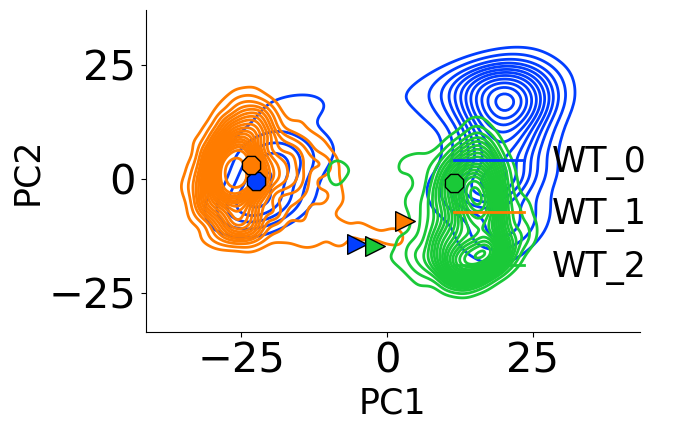

<Figure size 2000x2000 with 0 Axes>

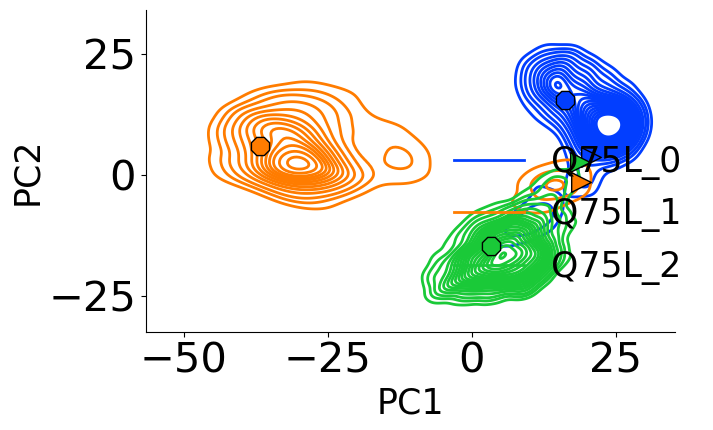

In [93]:
colors = sns.color_palette('bright', 3)
label_WT = np.asarray(['WT_0']*5000+['WT_1']*5000+['WT_2']*5000)
DimRedPlots.plot_pca_space(DR_WT.fitted_transformed, label_WT ,
                           'WT_0', rd + 'PTPA_PCA_WT.pdf', levels=20,
                           colors=colors, title='')
label_Q75L = np.asarray(['Q75L_0']*5000+['Q75L_1']*5000+['Q75L_2']*5000)
DimRedPlots.plot_pca_space(DR_Q75L.fitted_transformed, label_Q75L ,
                           'Q75L', rd + 'PTPA_PCA_Q75L.pdf', levels=20,
                           colors=colors, title='')